In [309]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
from numba import jit
import classy
from tqdm import tqdm
import pickle
import numba

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [3]:
import sys
sys.path.append('/home/addis/PkBk/Library')
sys.path.append('/home/addis/PkBk/Scripts')
import get_field as gf
import compute_grid_info as cgi
import Pk 
import Pk1 

In [5]:
#field things!
path = '../../../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'

In [6]:
def save_dict(pk_save):
    #save dictionary to particualar folder
    # create a binary pickle file 
    f_open = open('pk_dict_'+ red_info +'_' + str(N_side) + ".pkl","wb")
    # write the python object (dict) to pickle file
    
    pk_save['ks'] = k_est  #saves k_eq for future.
    pickle.dump(pk_save,f_open)
    # close file
    f_open.close()
    pk_save.pop('ks', None)#cos sometimes it sus

#save_dict(pk)   

with open('pk_dict_'+ red_info +'_' + str(N_side) + ".pkl", 'rb') as f:
    pk_load = pickle.load(f)
    ks_load = pk_load['ks'] #get ks
    pk_load.pop('ks', None) # remove ks from dict
pk = pk_load

In [8]:
print(pk['PP']['l=0'].shape)

(500, 32)


In [9]:
%%time
Nside=128
L=1000
rfft=False
order=2
obs_pos=(500,500,500) #
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
#xi,x_norm,ki,k_mag,MAS,k_f,k_ny

CPU times: user 3.6 s, sys: 164 ms, total: 3.77 s
Wall time: 4.07 s


In [10]:
%%time
iFFT=False
dtype=np.complex64
threads=4
verbose=True

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 11.2 µs


In [11]:
%%time
s=1 #units of 2*k_f
k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
#In_bin,N_modes

CPU times: user 736 ms, sys: 10.7 ms, total: 747 ms
Wall time: 760 ms


In [10]:
%%time
realisation = str(10016)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=Cen'+ '.npy') #load field
t= 0.5
l = 1
exorder = 2
Pk_ell = Pk.Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)
Pk_ell1 = Pk1.Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)

CPU times: user 46 s, sys: 8.94 s, total: 54.9 s
Wall time: 17.2 s


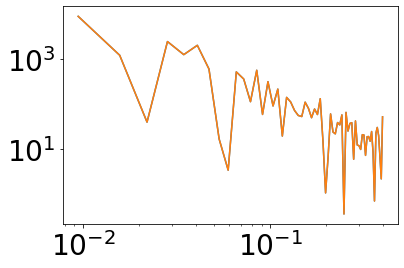

In [11]:
plt.loglog(k_est,np.abs(Pk_ell.pk))
plt.loglog(k_est,np.abs(Pk_ell1.pk))

In [13]:
#define empty dict to fill in...
pk1 = {
    'Cen' : {},#redshift space in centre
    '-500' : {},#z_obs
    '0':{},
    'PP' : {}, # PP with RSD
    'real': {}#real space
    } 

In [495]:
#pk['00'] ={}
#pk['000'] ={}
#pk['-1000'] ={}
#pk['250'] ={}
#pk['0_other'] ={}

#pk['-100'] ={}
#pk['100'] ={}
#pk['-250'] ={}
#pk['400'] ={}
#pk['-400'] ={}

In [219]:
def pk_realisations(field,init_dict,ls,ts,exorder,obs_pos,N_min,N_max):#add path so choose fields as were
    """function to run to calculate bispectrum for different multiplles over realisations"""
    pk_dict= init_dict.copy()
    N_side=128
    L=1000
    rfft=False
    order=2
    #obs_pos=(500,500,z_obs)#
    grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
    
    iFFT=False
    dtype=np.complex64
    threads=4
    verbose=True
    
    #s=1/2 #units of 2*k_f
    k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
    binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
    #In_bin,N_modes 
    
    for t in ts:#which LOS
        for l in ls:  #which multipoles to calculate
            key_mono = 'l=%d'%(0)
            key ='l=%d'%(l) +',t=' + str(t)[-1]

            arr_pk = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64) #create empty arrays in dict to store bispectra
            arr_mono = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64)
            for i in tqdm(range(N_min,N_max)):
                realisation = str(10000 + i)
                                                            #
                field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + field+ '.npy') #load field
                j = Pk.Pk(field_tmp,L,N_side,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)
                arr_pk[i-N_min] = j.pk
                if l % 2 == 0:
                    arr_mono[i-N_min] = j.mono
            
            #for resets...
            if key in pk_dict.keys():
                if len(pk_dict[key]) >= N_max - N_min:#in case of error just delete
                    pk_dict.pop(key, None)
                    pk_dict.pop(key_mono, None)
                
            if key in pk_dict.keys(): # create array with extra zeros beyond which has already been computed
                pk_dict[key] = np.concatenate((pk_dict[key][:N_min],arr_pk))
                if l % 2 == 0:#if even
                    pk_dict[key_mono] = np.concatenate((pk_dict[key_mono][:N_min],arr_mono))
            else:
                pk_dict[key] = arr_pk 
                pk_dict[key_mono] = arr_mono
                 
    return pk_dict

ls= [4]#
ts = [0]#

exorder = 0

obs_pos = (500,500,-1e+10)

field = 'PP'#str(obs_pos[-1]) #'Cen'#'0_other'#'000'# 'real'#
field_add = '_LOS='+field
if field == 'real': #real has a different naming convention for no reason
    field_add = ''
    
pk[field] = pk_realisations(field_add,pk[field],ls,ts,exorder,obs_pos,0,300)


100%|██████████| 300/300 [23:25<00:00,  4.69s/it]


In [15]:
print(pk['PP']['l=2,t=0'].shape)
print(obs_pos)

(500, 32)
(500, 500, -10000000000.0)


In [200]:
ls= [4]
#for doing all basic distanc ones in a loop
obs_pos_list = [(500,500,500),(500,500,400),(500,500,250),(500,500,100),(500,500,0),(500,500,-100),(500,500,-250),(500,500,-400),(500,500,-500),(500,500,-1000)]
for i,obs_pos in enumerate(obs_pos_list):
    field = str(obs_pos[-1]) #'0_other'#'000'#'Cen'# 'real'#'PP'#
    if obs_pos[-1] == 500:
        field = 'Cen'
    field_add = '_LOS='+field
    pk[field] = pk_realisations(field_add,pk[field],ls,ts,exorder,obs_pos,0,100)

100%|██████████| 100/100 [06:54<00:00,  4.15s/it]


In [220]:
def avg_err(Pk):#ok so adapt to nested dict structure...
    Pk_avg = {}
    Pk_err = {}
    Pk_std = {}
    for i in Pk.keys():#so this loops over each type - i.e. PP,Cen,real_space
        Pk_avg[i] = {}#create the nested dictionary to fill...
        Pk_err[i] = {}
        Pk_std[i] = {}
        for j in Pk[i].keys(): # loop over multipole keys - to get mean and std for each
            Pk_avg[i][j] = np.mean((Pk[i][j]),axis=0)
            Pk_err[i][j] = np.std(Pk[i][j],axis=0)/np.sqrt(len(Pk[i][j])) # standard error makes sense as we have independent realisations
            Pk_std[i][j] = np.std(Pk[i][j],axis=0)
    return Pk_avg,Pk_err,Pk_std

Pk_avg,Pk_err,Pk_std = avg_err(pk)

In [113]:
def get_chi(A_wa,PP_th,wa_th,data_mean,data_err):
    """calculate chi squared for data..."""
    chi_arr = np.zeros((len(A_wa)))
    for i in range(len(A_wa)):
        chi_arr[i] = np.sum((data_mean - (PP_th+A_wa[i]*wa_th))**2 /data_err**2)
    return chi_arr

def get_likelihood(A_wa,PP_th,wa_th,data_mean,data_err):
    """Get likelihood from get_chi"""
    return np.exp(-get_chi(A_wa,PP_th,wa_th,data_mean,data_err)/2)

def likelihood_confidence(likelihood,conf_level):
    """Get indexes of A_wa for a given confidence limit"""
    cum = np.cumsum(likelihood)
    
    norm = cum.max()
    index_high = np.argmax(cum/norm >= conf_level)
    index_low = np.argmax(cum/norm >= 1-conf_level)
    return index_low,index_high

In [114]:
def get_avg_dist(obs_pos):
    """create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)"""
    Nside_theory= 128
    conf_space = np.linspace(0,1000,Nside_theory)
    x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
    conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
    ds = np.where(conf_norm==0,1,conf_norm)
    return 1/np.mean(1/ds)

print(get_avg_dist((500,500,-500)))

#print(np.sqrt(1000**2+250**2+250**2))
print((1000**3)/(4*np.pi *(1060**2-500**2)/2))
#print(1000**3)

1012.9269072881068
182.18285610336005


In [115]:
A_wa = np.linspace(-20,20,10000) #define A_wa sampling
field_list = ['Cen','400','250','100','0','-100','-250','-400','-500','-1000']
d_arr = np.array([0,100,250,400,500,600,750,900,1000,1500])
d_arr_avg = np.zeros_like(d_arr)
for i,dd in enumerate(d_arr):
    obs_pos = (500,500,500-dd)
    d_arr_avg[i] = get_avg_dist(obs_pos)
#obs_pos_list = []

In [571]:
def get_best_fit():#pp_th,pp_wa,est_pk,est_std
    sigma = 2.5
    #t=0
    A_arr = np.zeros(len(field_list))
    A_arr_err = np.zeros(len(field_list))
    for i,key in enumerate(field_list):

        use_d = d_arr_avg[i] #d_arr_avg[i]
        use_ks = 6
        min_ks = 2
        #like_test = get_likelihood(A_wa,0,pk_dipo_dfog_wa(k_est,sigma,use_d,0).imag[min_ks:use_ks],Pk_avg[key]['l=1,t=0'].imag[min_ks:use_ks],Pk_std[key]['l=1,t=0'][min_ks:use_ks])
        #like_test = get_likelihood(A_wa,pk_quad_dfog(k_est,sigma)[min_ks:use_ks], pk_quad_dfog_wa(k_est,sigma,use_d,t).real[min_ks:use_ks],Pk_avg[key]['l=2,t=0'].real[min_ks:use_ks],Pk_std[key]['l=2,t=0'][min_ks:use_ks])
        like_test = get_likelihood(A_wa,0,pk_octo_dfog_wa(k_est,sigma,use_d,0).imag[min_ks:use_ks],Pk_avg[key]['l=3,t=0'].imag[min_ks:use_ks],Pk_std[key]['l=3,t=0'][min_ks:use_ks])
        #like_test = get_likelihood(A_wa,pk_hexa_dfog(k_est,sigma)[min_ks:use_ks], pk_hexa_dfog_wa(k_est,sigma,use_d,t).real[min_ks:use_ks],Pk_avg[key]['l=4,t=0'].real[min_ks:use_ks],Pk_std[key]['l=4,t=0'][min_ks:use_ks])
        
        #combine everything...
        pp_pk = np.concatenate((np.zeros(use_ks-min_ks),pk_quad_dfog(k_est,sigma)[min_ks:use_ks],np.zeros(use_ks-min_ks),pk_hexa_dfog(k_est,sigma)[min_ks:use_ks]))
        wa_pk = np.concatenate((pk_dipo_dfog_wa(k_est,sigma,use_d,0).imag[min_ks:use_ks],pk_quad_dfog_wa(k_est,sigma,use_d,0).real[min_ks:use_ks],pk_octo_dfog_wa(k_est,sigma,use_d,0).imag[min_ks:use_ks],pk_hexa_dfog_wa(k_est,sigma,use_d,0).real[min_ks:use_ks]))
        est_pk = np.concatenate((Pk_avg[key]['l=1,t=0'].imag[min_ks:use_ks],Pk_avg[key]['l=2,t=0'].real[min_ks:use_ks],Pk_avg[key]['l=3,t=0'].imag[min_ks:use_ks],Pk_avg[key]['l=4,t=0'].real[min_ks:use_ks]))
        est_std = np.concatenate((Pk_std[key]['l=1,t=0'][min_ks:use_ks],Pk_std[key]['l=2,t=0'][min_ks:use_ks],Pk_std[key]['l=3,t=0'][min_ks:use_ks],Pk_std[key]['l=4,t=0'][min_ks:use_ks]))
        
        #like_test = get_likelihood(A_wa,pp_pk,wa_pk,est_pk,est_std)
        low_lim = likelihood_confidence(like_test,0.66)[0]
        A_arr[i] = A_wa[np.argmax(like_test)]
        A_arr_err[i] = np.abs(A_arr[i]-A_wa[low_lim])
    return A_arr,A_arr_err

A_arr3,A_arr_err3 = get_best_fit()



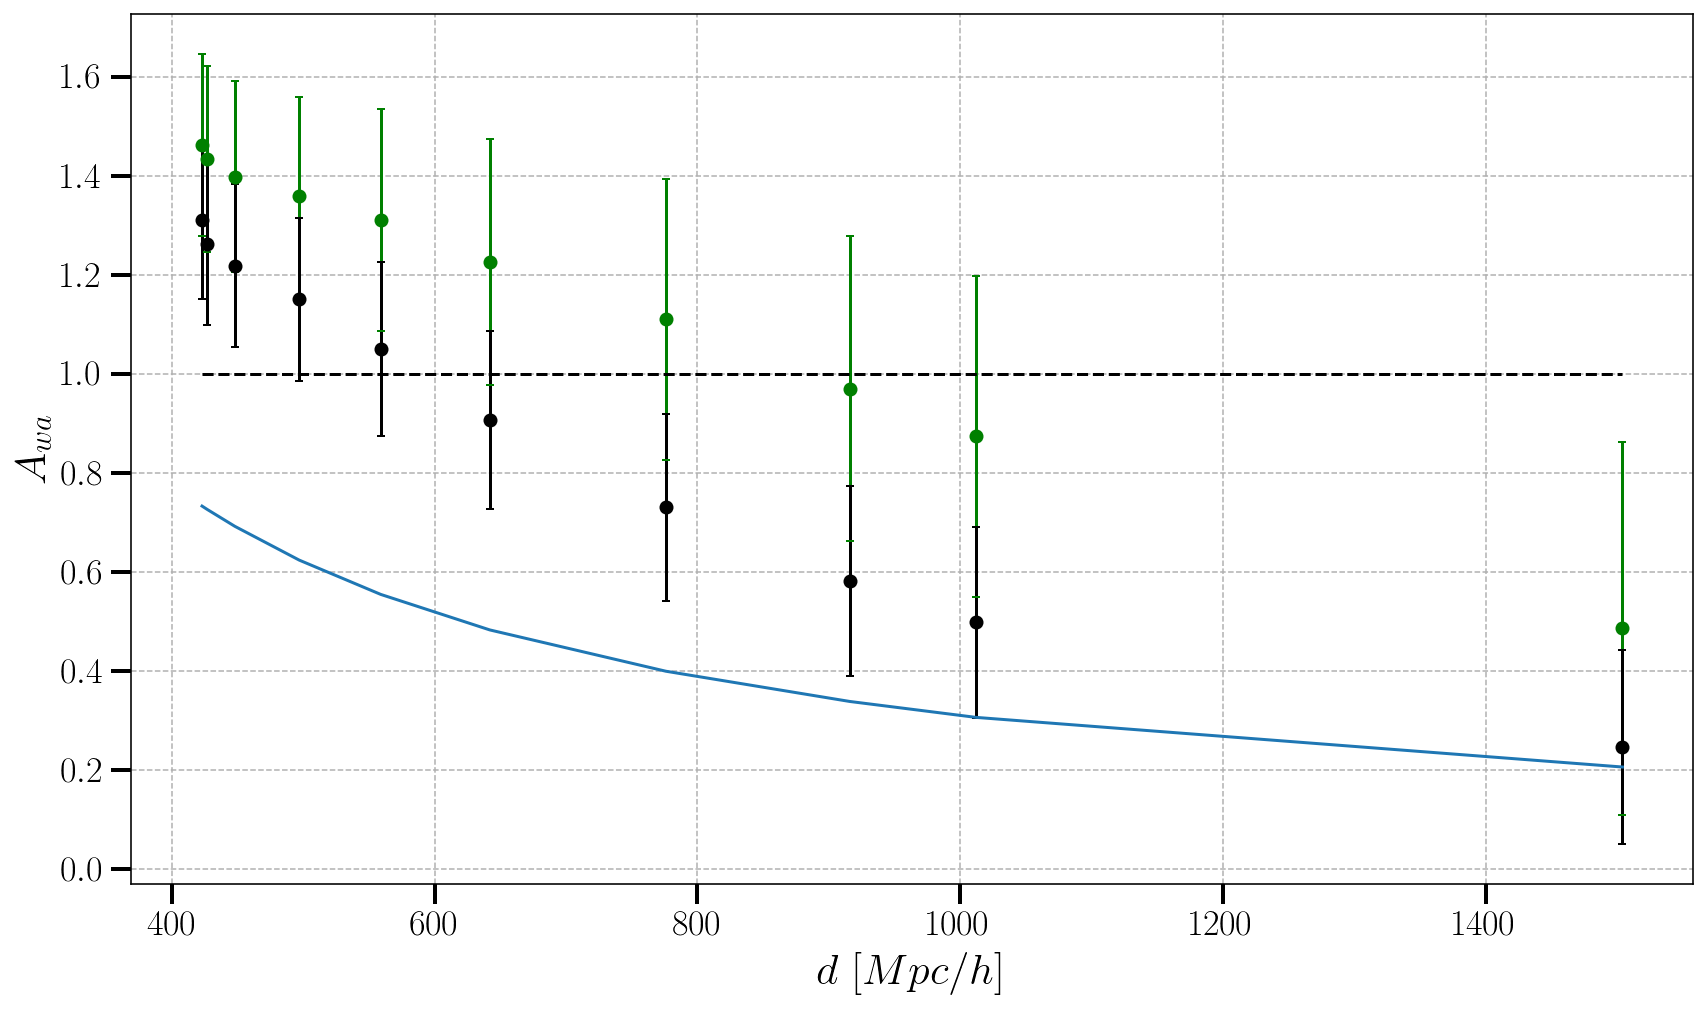

In [572]:
plt.figure(figsize=(14,8))
#plt.errorbar(d_arr_avg,A_arr1,yerr=A_arr_err1,fmt ='o',linestyle='none',capsize=2,color='blue')
#plt.errorbar(d_arr_avg,A_arr2,yerr=A_arr_err2,fmt ='o',linestyle='none',capsize=2,color='red')
plt.errorbar(d_arr_avg,A_arr3,yerr=A_arr_err3,fmt ='o',linestyle='none',capsize=2,color='green')
#plt.errorbar(d_arr_avg,A_arr4,yerr=A_arr_err4,fmt ='o',linestyle='none',capsize=2,color='orange')

plt.errorbar(d_arr_avg,A_arr,yerr=A_arr_err,fmt ='o',linestyle='none',capsize=2,color='black')
plt.plot(d_arr_avg, np.ones_like(d_arr_avg),color='black',linestyle='--')
plt.plot(d_arr_avg, np.ones_like(d_arr_avg)*310/d_arr_avg)
#plt.plot(d_arr, 1000**2/(d_arr_avg)**2 /np.pi)
#plt.yscale('log')
#plt.ylim(-1,4)
plt.grid(ls='--',lw=0.75)
plt.ylabel('$A_{wa}$')
plt.xlabel(' $d \ [Mpc/h]$')
plt.savefig('Quad_A_wa',dpi=400,bbox_inches='tight')

In [381]:
#Extra wide-angle contributions...
def pk_quad_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 5*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-4*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 24) - t*(16*kk**2*sigma**2 + 24) - 15) + 4*b1*f*kk**3*sigma**3*(-16*kk**8*sigma**8 - 80*kk**6*sigma**6 - 180*kk**4*sigma**4 - 381*kk**2*sigma**2 + t**2*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - t*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8*(-2*kk**2*sigma**2 - 8*t**2 + 8*t + 5) + 6*b1*f*kk**2*sigma**2*(2*kk**4*sigma**4 + 27*kk**2*sigma**2 + t**2*(264*kk**2*sigma**2 - 1800) - t*(264*kk**2*sigma**2 - 1800) + 150) + f**2*(-14*kk**6*sigma**6 + 297*kk**4*sigma**4 - 2385*kk**2*sigma**2 - t**2*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + t*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + 12285)) + 2*f**2*kk*sigma*(-16*kk**10*sigma**10 - 112*kk**8*sigma**8 - 484*kk**6*sigma**6 - 1983*kk**4*sigma**4 - 5805*kk**2*sigma**2 + t**2*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - t*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - 12285)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(24*kk**4*sigma**4 + 138*kk**2*sigma**2 - t**2*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + t*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-96*kk**6*sigma**6 - 328*kk**4*sigma**4 - 858*kk**2*sigma**2 + t**2*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - t*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(16*kk**6*sigma**6 - 20*kk**4*sigma**4 + 36*kk**2*sigma**2 + t**2*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) - t*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) + 15) + 4*b1*f*kk**2*sigma**2*(16*kk**6*sigma**6 + 44*kk**4*sigma**4 - 108*kk**2*sigma**2 + t**2*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - t*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - 1125) + f**2*(112*kk**6*sigma**6 - 1548*kk**4*sigma**4 + 10620*kk**2*sigma**2 + t**2*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - t*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - 36855)) + 2*f**2*kk*sigma*(192*kk**8*sigma**8 + 896*kk**6*sigma**6 + 4296*kk**4*sigma**4 + 13950*kk**2*sigma**2 - t**2*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + t*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + 36855)) - Pkdd*kk*(8*b1**2*kk**5*sigma**5*(4*kk**4*sigma**4 + 12*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-28*kk**4*sigma**4 - 96*kk**2*sigma**2 + t**2*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - t*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(8*kk**6*sigma**6 - 4*kk**4*sigma**4 + 18*kk**2*sigma**2 + t**2*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - t*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - 45) - 4*b1*f*kk**2*sigma**2*(8*kk**6*sigma**6 + 4*kk**4*sigma**4 - 54*kk**2*sigma**2 - t**2*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + t*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + 225) + f**2*(56*kk**6*sigma**6 - 492*kk**4*sigma**4 + 1950*kk**2*sigma**2 + t**2*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - t*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - 4095)) + 2*f**2*kk*sigma*(64*kk**6*sigma**6 + 284*kk**4*sigma**4 + 780*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + t*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + 4095))))/(512*d**2*kk**11*sigma**9)



def pk_dipo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return 3*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(Pkd*kk*(-8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*kk**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*kk**6*sigma**6 + 45*f**2 - 3*f*kk**2*sigma**2*(-6*b1 + f))) + 2*kk*sigma*(-Pkd*kk*(45*f**2 + 12*f*kk**2*sigma**2*(3*b1 + 2*f) + kk**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*kk**4*sigma**4*(6*b1 + 5*f) + 9*f*kk**2*sigma**2*(2*b1 + 3*f) + 4*kk**6*sigma**6*(b1 + f)**2)))/(32*d*kk**8*sigma**7)
            

In [1122]:
print(np.argmin(get_chi(A_wa,pk_quad_dfog(k_est,sigma)[:5],pk_quad_dfog_wa(k_est,sigma,560,0)[:5],Pk_avg['PP']['l=2,t=0'].real[:5],Pk_std['PP']['l=2,t=0'][:5])))
#print(np.min(get_chi(A_wa,pk_quad_dfog(k_est,sigma)[:5],pk_quad_dfog_wa(k_est,sigma,560,0)[:5],Pk_avg['0']['l=2,t=0'].real[:5],Pk_std['0']['l=2,t=0'][:5])))

2788


In [1123]:
print(A_wa[2788])

1.1542308461692343


0.9180918091809183 -1.7661766176617668 3.6023602360236033


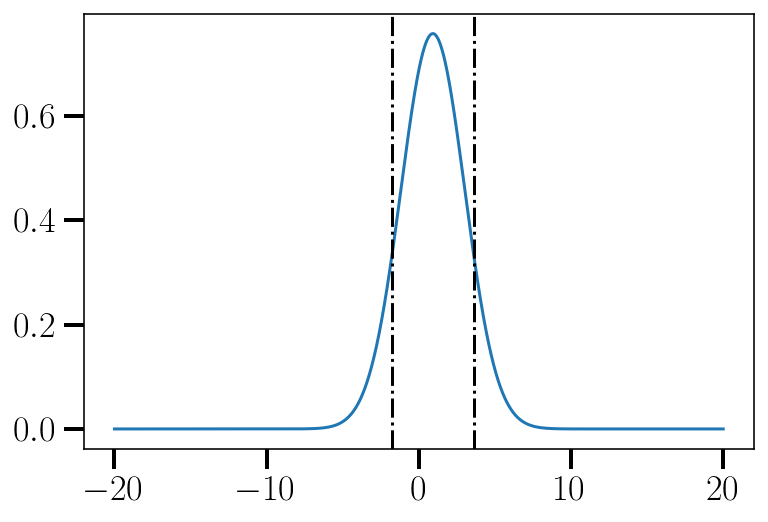

In [1129]:
#so for quad...
#likelihood2 = get_likelihood(A_wa,pk_quad_dfog(k_est,sigma)[:5],0,Pk_avg['PP']['l=2,t=0'].real[:5],Pk_std['PP']['l=2,t=0'][:5])
#likelihood1 = get_likelihood(A_wa,0,pk_dipo_dfog_wa(k_est,sigma,1000,0)[:9],-Pk_avg['0']['l=1,t=0'].imag[:9],Pk_std['-500']['l=1,t=0'][:9])

key = '0'
#dipole
#likelihood = get_likelihood(A_wa,0,pk_dipo_dfog_wa(k_est,sigma,560,0)[:9],-Pk_avg[key]['l=1,t=0'].imag[:9],Pk_std[key]['l=1,t=0'][:9])
#quad
likelihood = get_likelihood(A_wa,pk_quad_dfog(k_est,sigma)[:5],pk_quad_dfog_wa(k_est,sigma,500,0)[:5],Pk_avg['PP']['l=2,t=0'].real[:5],Pk_std['PP']['l=2,t=0'][:5])
low,high = likelihood_confidence(likelihood,0.90)
plt.plot(A_wa,likelihood)
plt.axvline(x = A_wa[low], linestyle='-.', color = 'black')
plt.axvline(x = A_wa[high], linestyle='-.', color = 'black')
print(A_wa[np.argmax(likelihood)],A_wa[low],A_wa[high])

In [836]:
print(pk1['PP']['l=2,t=0'].shape)

(100, 32)


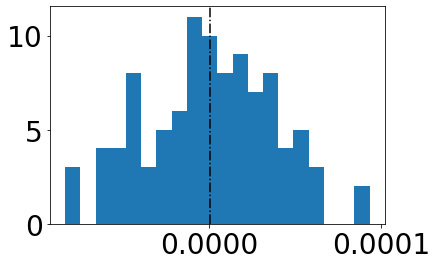

In [662]:
key = 'PP'
k_ind = 7
plt.hist(pk[key]['l=1,t=0'][:,k_ind].imag,bins=20)
#plt.axvline(x = -pk_dipo_dfog_wa(k_est,sigma,1000,0)[1], linestyle='-.', color = 'black')
plt.axvline(x = Pk_avg[key]['l=1,t=0'].imag[k_ind], linestyle='-.', color = 'black')

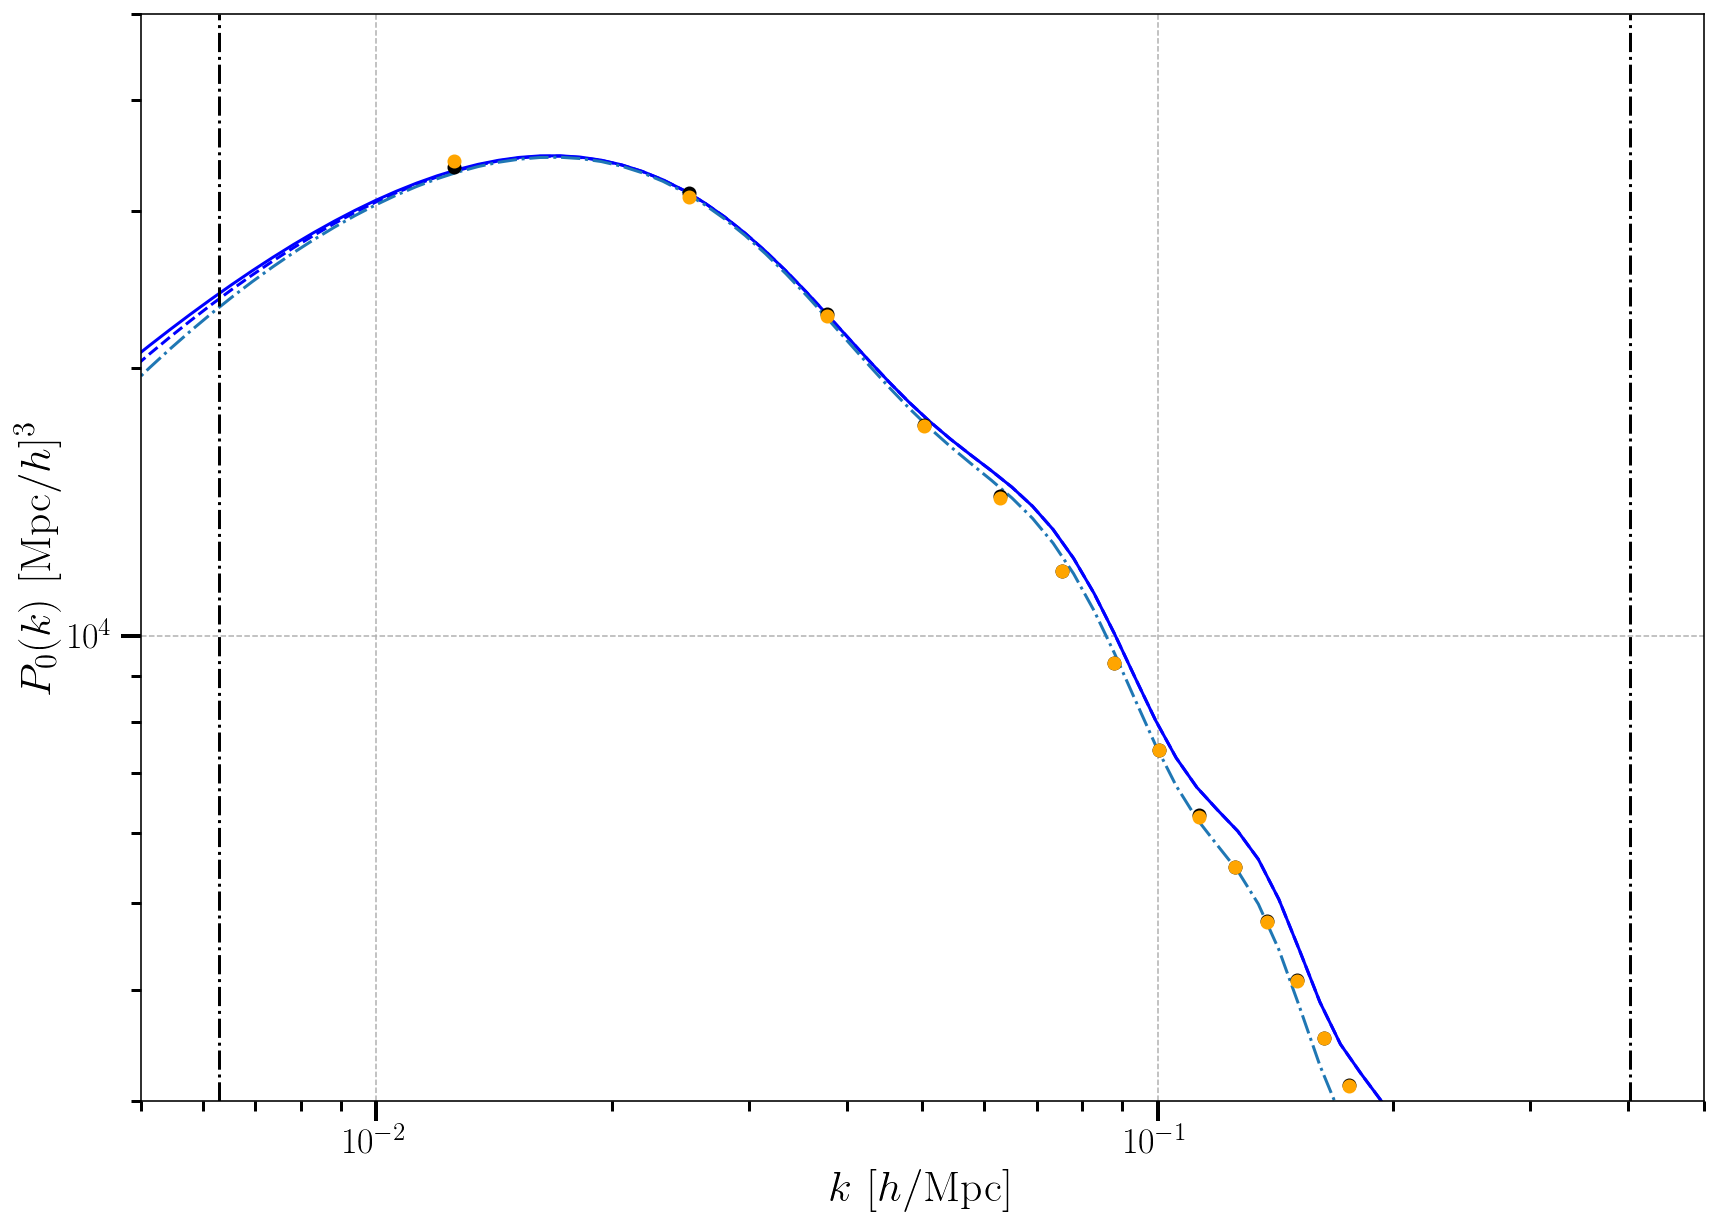

In [444]:
#monopole!!!
plt.figure(figsize=(14,10))

#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=0'].real),yerr=Pk_err['0']['l=0'],fmt ='o',color='blue')
plt.errorbar(k_est,(Pk_avg['Cen']['l=0'].real),yerr=Pk_err['Cen']['l=0'],fmt ='o',color='black')
plt.errorbar(k_est,(Pk_avg['PP']['l=0'].real),yerr=Pk_err['PP']['l=0'],fmt ='o',color='orange')

plt.loglog(ks,Pl0_pp,'-',color='blue')
plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
plt.plot(ks,pk_mono_dfog(ks,4)+pk_mono_dfog_wa(ks,4,430,0),'-.')

plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(5e-3,0.5e0)
plt.ylim(3e+3,5e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{0}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

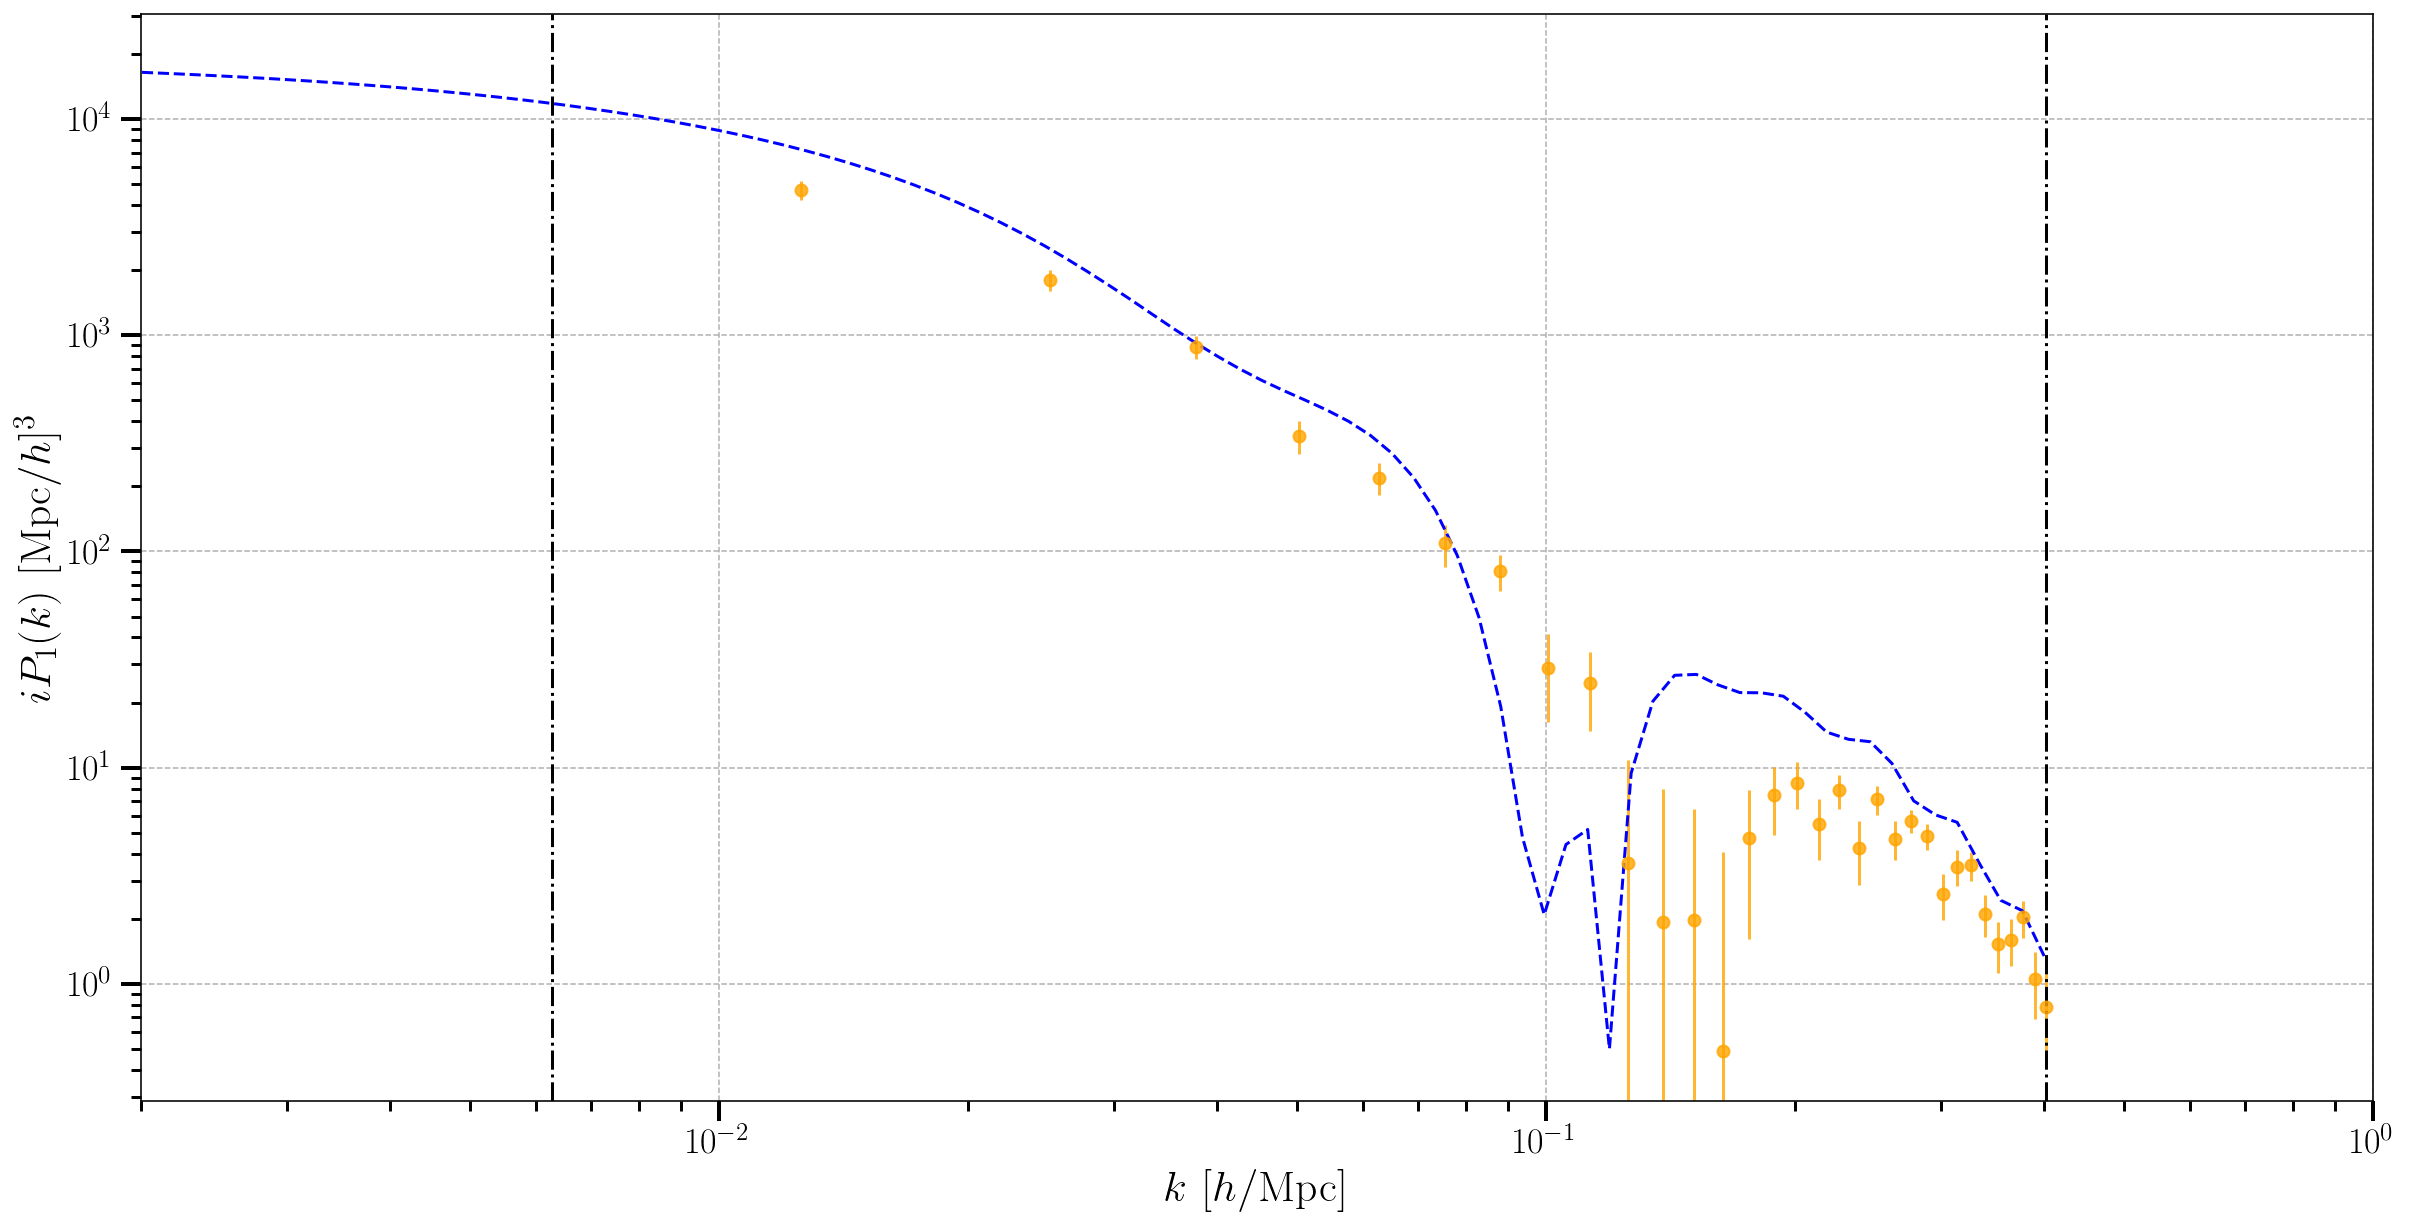

In [553]:
#dipole!!!
plt.figure(figsize=(20,10))

key1 = 'Cen'

#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=1,t=0']),yerr=Pk_err['0']['l=1,t=0'],fmt ='o',linestyle='none',alpha=0.8)
#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=1,t=5']),yerr=Pk_err['0']['l=1,t=5'],fmt ='o',linestyle='none',alpha=0.8)

plt.errorbar(k_est,np.abs(Pk_avg[key1]['l=1,t=0']),yerr=Pk_err[key1]['l=1,t=0'],fmt ='o',linestyle='none',color='orange',alpha=0.8)
#plt.errorbar(k_est,np.abs(Pk_avg['0_other']['l=1,t=0']),yerr=Pk_err['0_other']['l=1,t=0'],fmt ='o',linestyle='none',color='red',alpha=0.8)

#plt.errorbar(k_est,np.abs(Pk_avg['-500']['l=1,t=5']),yerr=Pk_err['-500']['l=1,t=5'],fmt ='o',linestyle='none',color='red',alpha=0.8)

for i in range(100):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')


#plt.plot(ks,np.abs(dip_dfog(ks,5,560,0)))
plt.plot(ks, np.abs(pk_dipo_dfog_wa1(ks,5.3,430,0)),color='blue',linestyle='--')

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
plt.xlim(2e-3,1e0)
#plt.ylim(-1e+4,1e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.yscale('log')
plt.xscale('log')
plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

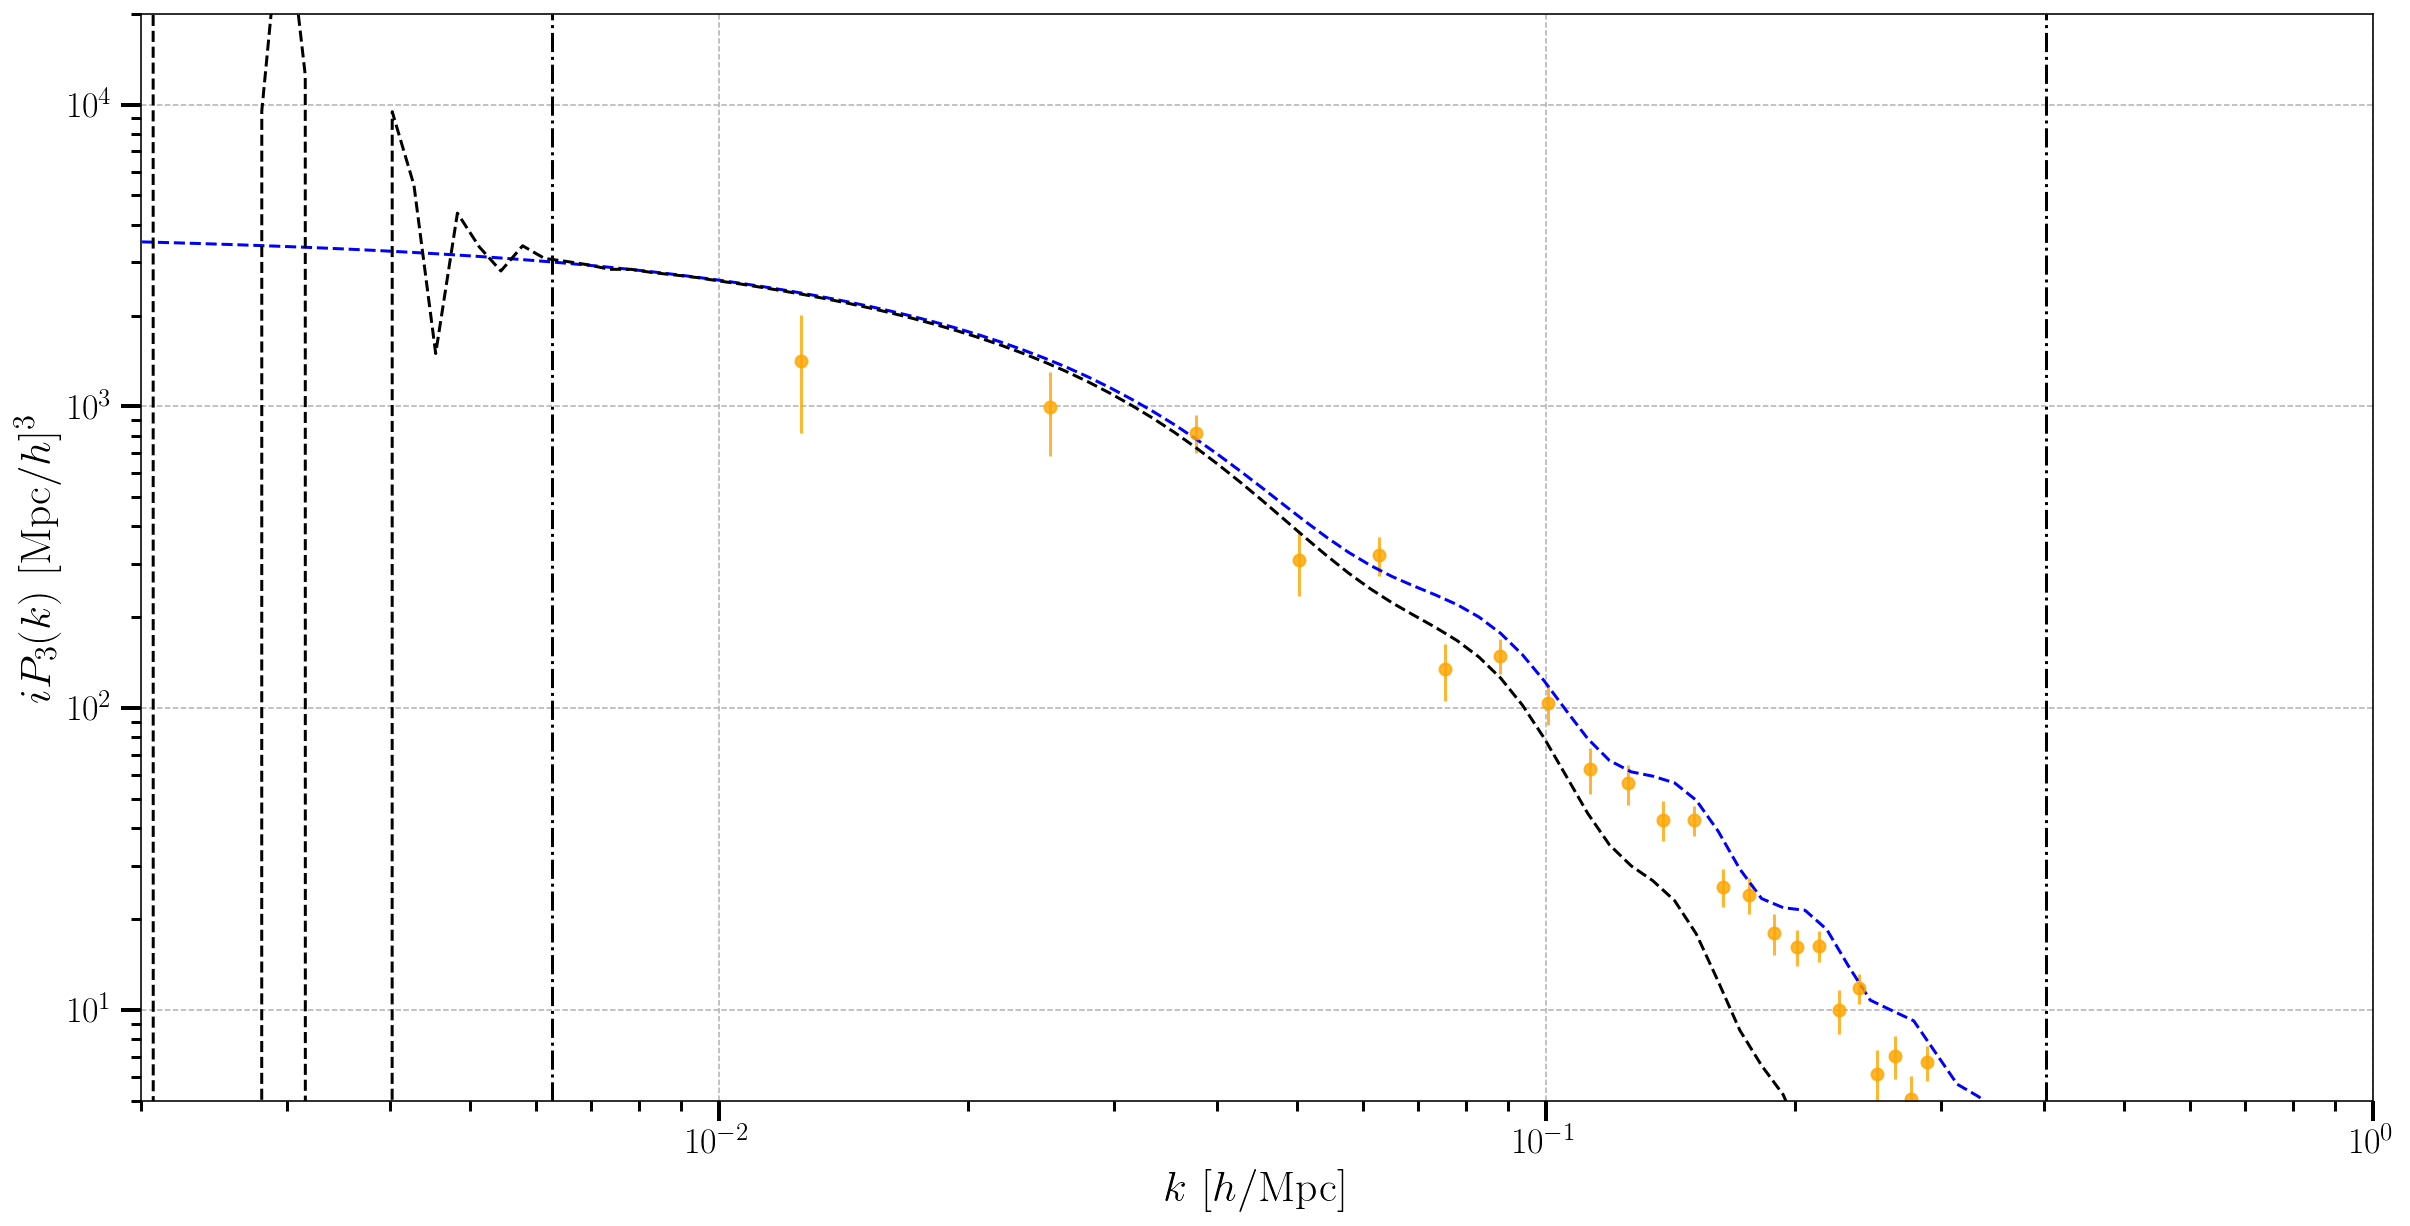

In [580]:
#octupole!!!
plt.figure(figsize=(20,10))

key1 = '-500'
plt.errorbar(k_est,-(Pk_avg[key1]['l=3,t=0']).imag,yerr=Pk_err[key1]['l=3,t=0'],fmt ='o',linestyle='none',color='orange',alpha=0.8)

for i in range(100):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')


plt.plot(ks,-(pk_oct(ks,1000,0).imag),color='blue',linestyle='--')
plt.plot(ks,-(pk_octo_dfog_wa(ks,5.3,1000,0).imag),color='black',linestyle='--')

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
plt.xlim(2e-3,1e0)
plt.ylim(0.5e+1,2e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{3}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.yscale('log')
plt.xscale('log')
plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

In [985]:
print(pk['PP'].keys())

dict_keys(['l=1,t=0'])


In [1051]:
def slice_realisations(key,key1,low,high):
    temp_arr = 1*pk[key][key1]
    pk1[key][key1] = temp_arr[low:high]#this the way to change without chopping og
    print(pk1[key][key1].shape)
    return avg_err(pk1)

Pk_avg1,Pk_err1,Pk_std1 = slice_realisations('PP','l=2,t=0',0,400)
Pk_avg2,Pk_err2,Pk_std2 = slice_realisations('0','l=2,t=0',350,400)
print(pk['PP']['l=2,t=0'].shape)


(400, 32)
(50, 32)
(500, 32)


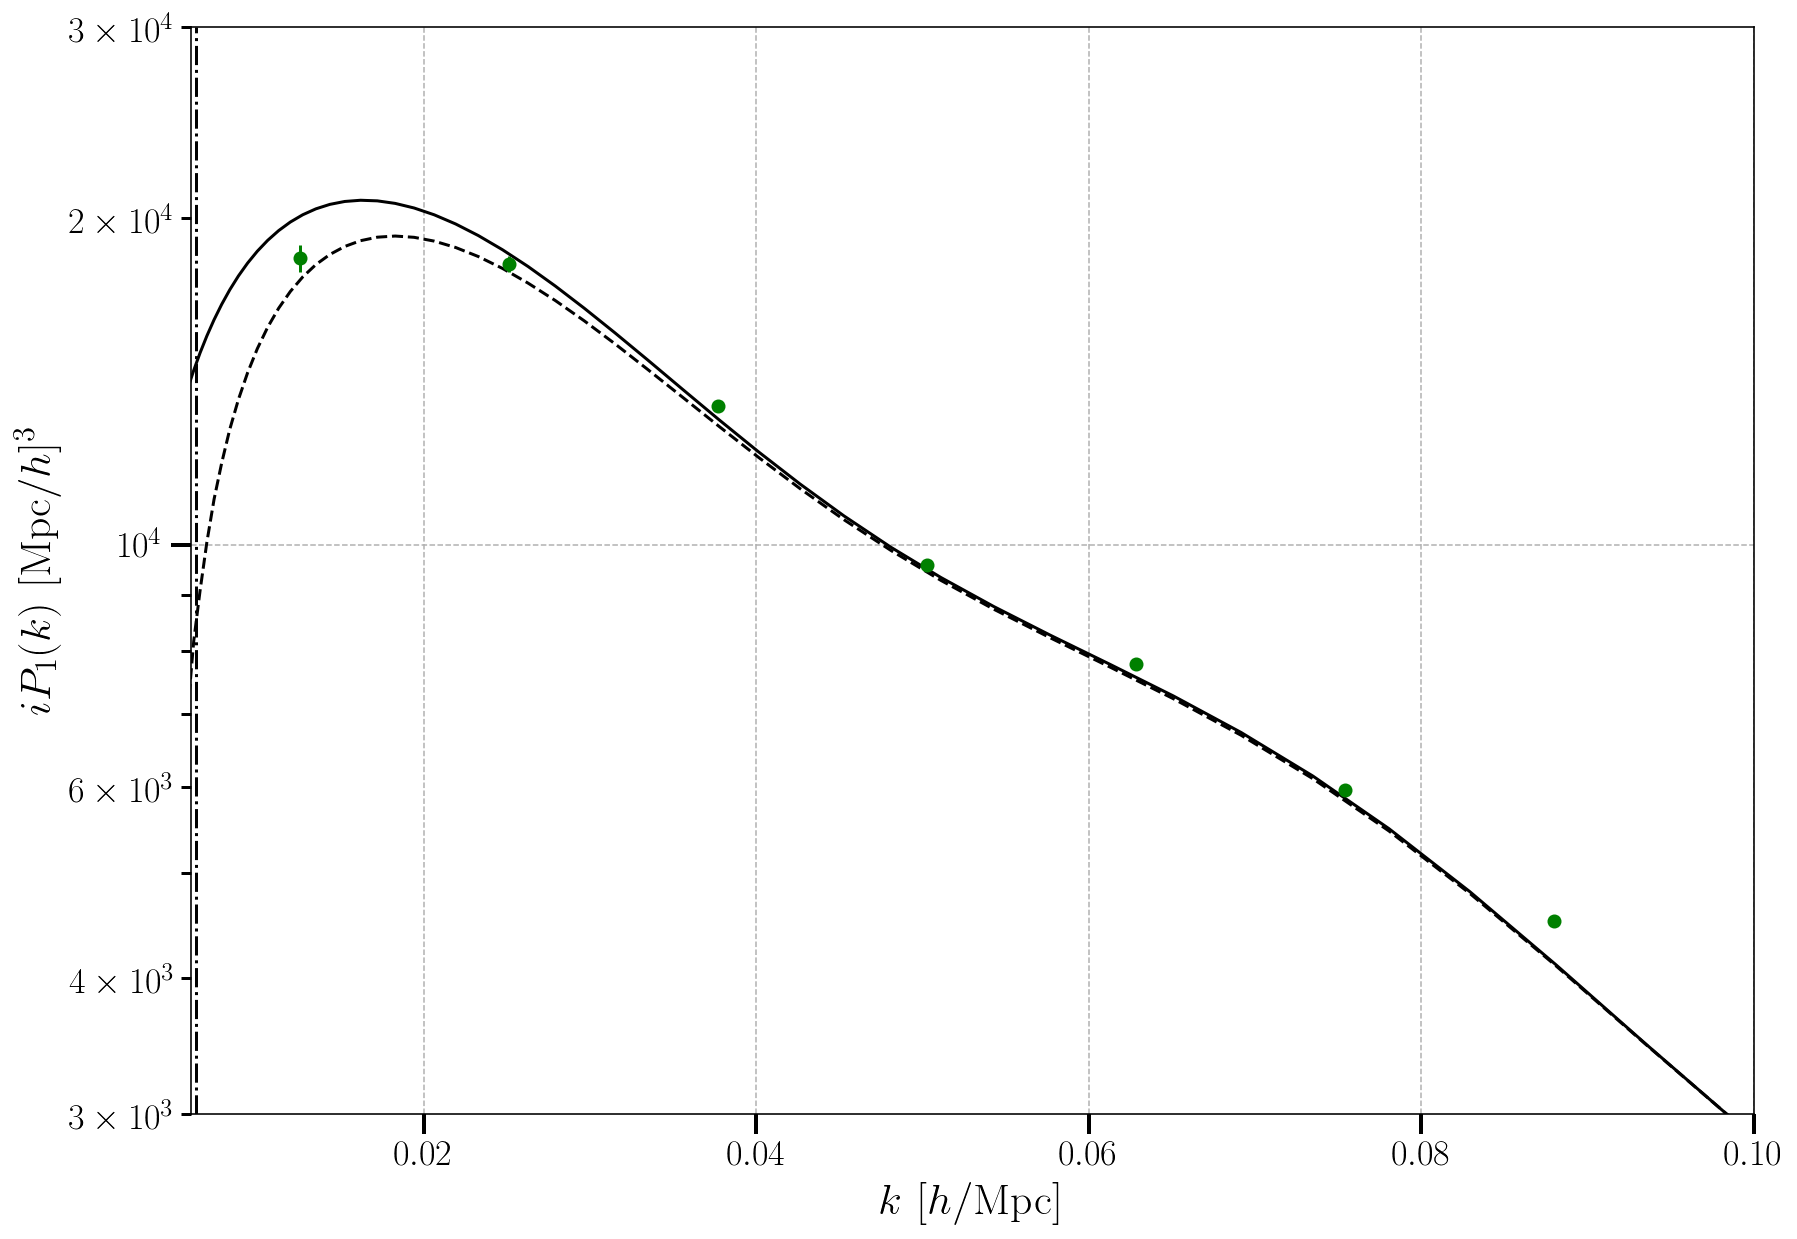

In [408]:
#quadrupole
plt.figure(figsize=(14,10))

plt.errorbar(k_est,np.abs(Pk_avg['PP']['l=2,t=0'].real),yerr=Pk_err['PP']['l=2,t=0'],fmt ='o',color='green')
#plt.errorbar(k_est,np.abs(Pk_avg1['PP']['l=2,t=0'].real),yerr=Pk_err1['PP']['l=2,t=0'],fmt ='o',color='red')
#plt.errorbar(k_est,np.abs(Pk_avg2['0']['l=2,t=0'].real),yerr=Pk_err2['0']['l=2,t=0'],fmt ='o',color='black')

#plt.errorbar(k_est,(Pk_avg['0']['l=2,t=0'].real),yerr=Pk_err['0']['l=2,t=0'],fmt ='o',color='black')

#plt.plot(ks,np.abs(full_dfog(ks,5.22,0)))


#plt.plot(ks,np.abs(pk_dfog(ks,5)),'--',color='black')
#plt.plot(ks,np.abs(wa_dfog(ks,5,560,0)),'--',color='green')
#plt.plot(ks,np.abs(wa_dfog(ks,5,1000,0)),'--',color='red')

plt.plot(ks, pk_quad_dfog(ks,5.3),color='black')
plt.plot(ks, pk_quad_dfog(ks,5.3)+pk_quad_dfog_wa(ks,5.3,500,0),color='black',linestyle='--')
#
#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    1#plt.loglog(k_est,(np.abs(pk_500['l=2,t=5'][i].real)),'.',alpha=0.2,color='blue')
    1#plt.loglog(k_est,(np.abs(pk_500['l=2,t=0'][i].real)),'.',alpha=0.2,color='red')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.1e0)
plt.ylim(3e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

#plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')

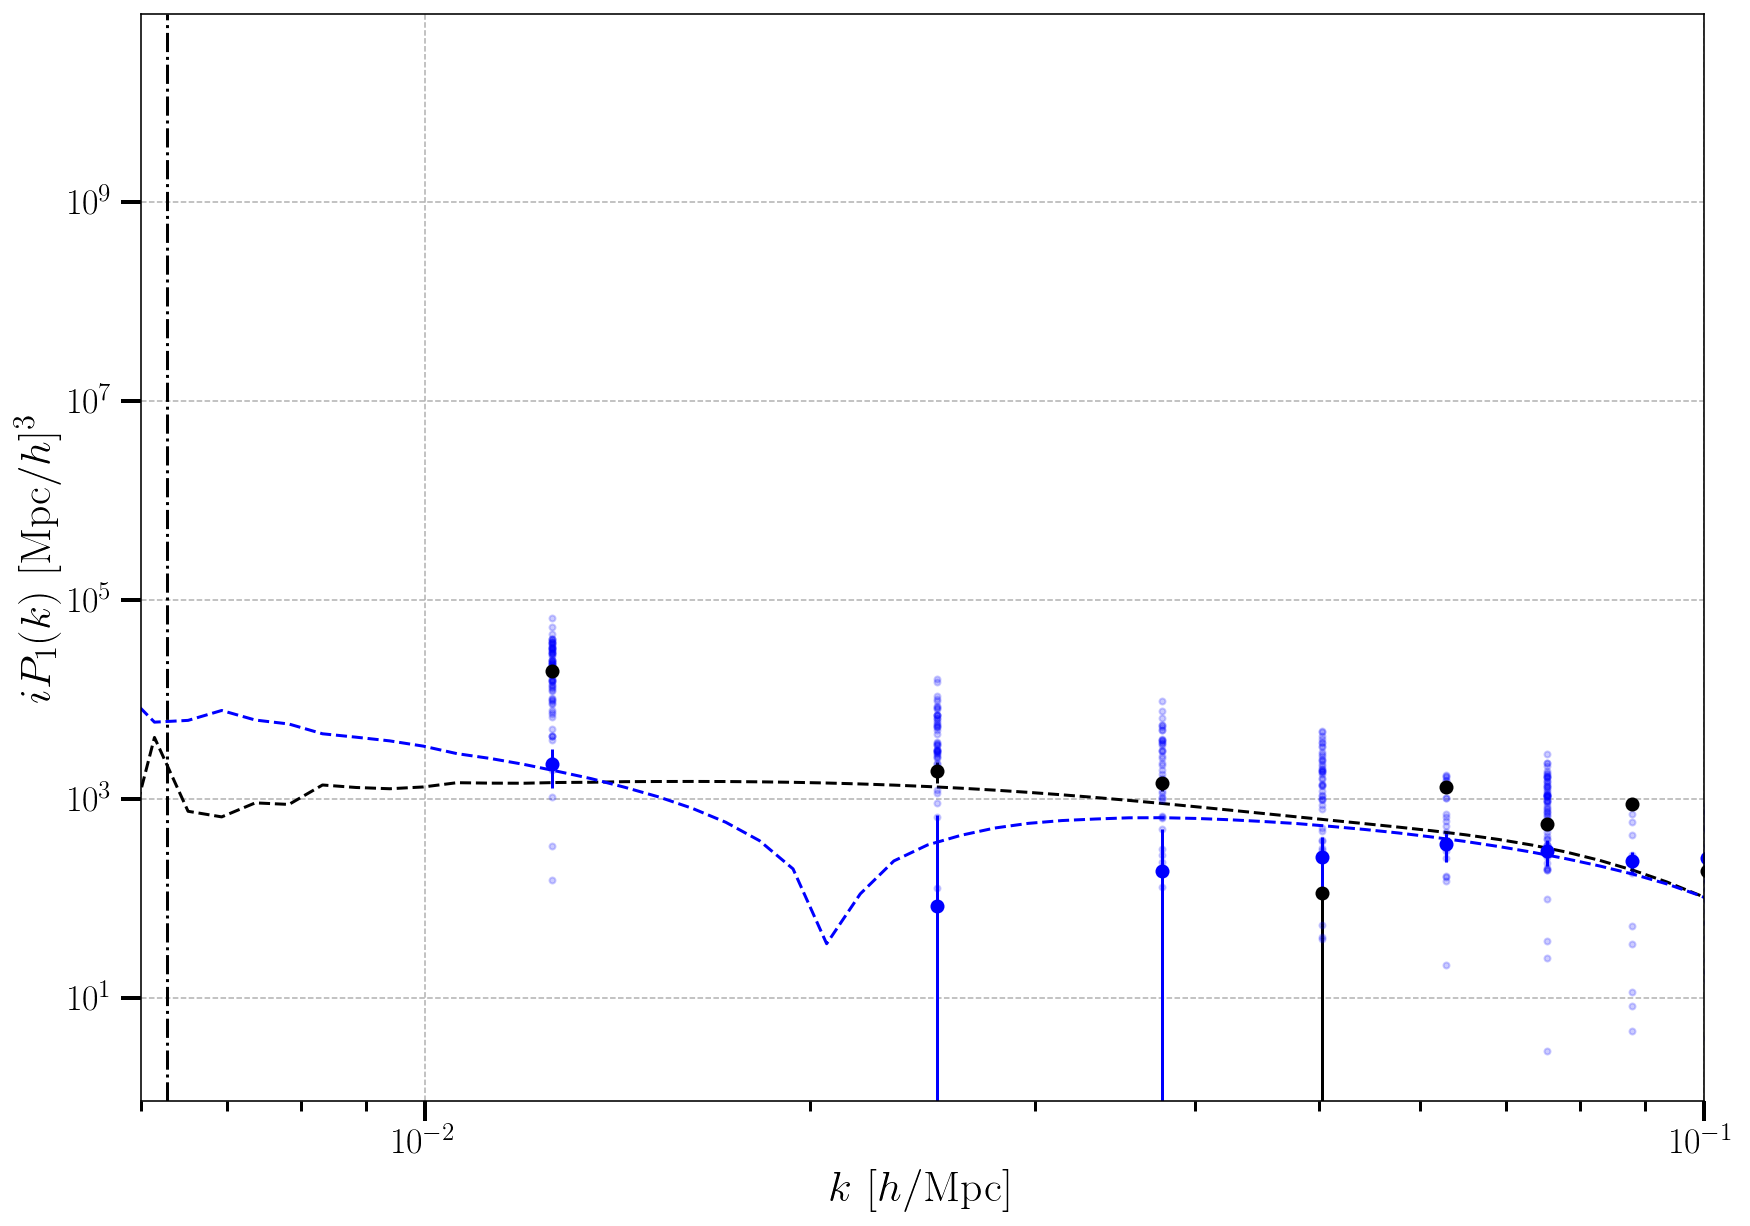

In [547]:
#quadrupole
plt.figure(figsize=(14,10))

plt.errorbar(k_est,np.abs(Pk_avg['PP']['l=4,t=0'].real),yerr=Pk_err['PP']['l=4,t=0'],fmt ='o',color='black')
#plt.errorbar(k_est,np.abs(Pk_avg['-1000']['l=4,t=0'].real),yerr=Pk_err['-1000']['l=4,t=0'],fmt ='o',color='red')
plt.errorbar(k_est,np.abs(Pk_avg['Cen']['l=4,t=0'].real),yerr=Pk_err['Cen']['l=4,t=0'],fmt ='o',color='blue')

sigma=4
#plt.plot(ks, Pl4_pp,color='black')
plt.plot(ks, np.abs(pk_hexa_dfog(ks,sigma)),linestyle='--',color='black')
plt.plot(ks, np.abs(pk_hexa_dfog(ks,sigma)+pk_quad_dfog_wa(ks,sigma,430,0)),linestyle='--',color='blue')
#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    plt.plot(k_est,-(pk['PP']['l=4,t=0'][i].real),'.',alpha=0.2,color='blue')
    1#plt.plot(k_est,(np.abs(pk_500['l=2,t=0'][i].real)),'.',alpha=0.2,color='red')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.1e0)
#plt.ylim(1e+1,2e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')

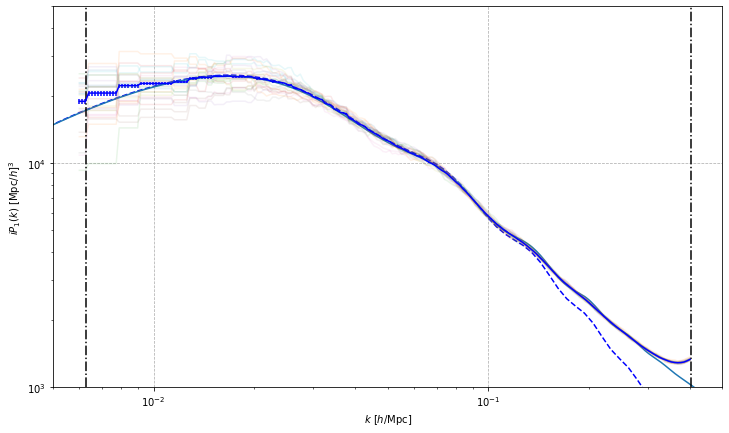

In [464]:
#real space
plt.figure(figsize=(12,7))


plt.errorbar(k_est,np.abs(Pk_avr['real']['l=0']),yerr=Pk_err['real']['l=0'],color='blue')
plt.plot(ks[10:],Pks[10:],'--',color='blue')
plt.plot(k,Pnonlin)
#plt.loglog(k_py,Pk0)
#plt.errorbar(k_est,np.abs(Pk_avg_real['l=2,t=0'].real),yerr=Pk_err_real['l=2,t=0'],color='red')
#plt.plot(ks,Pl2_pp+Pk_l2_wa,'--',color='red')


for i in range(25):
    plt.loglog(k_est,(np.abs(pk_real['l=0'][i].real)),alpha=0.1)


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(5e-3,0.5e0)
plt.ylim(1e+3,5e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)

In [739]:
%%time
import sys
sys.path.append('/home/addis/Pylians3/library/build/lib.linux-x86_64-3.8')
import Pk_library as PKL
BoxSize = 1000.0 #Mpc/h
axis    = 2
MAS     = 'CIC'
threads = 4
realisation = str(10002)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=PP' +'.npy')
Pk_py = PKL.Pk(np.array(field_tmp,dtype=np.float32), L, axis, MAS, threads, True)


Computing power spectrum of the field...
Time to complete loop = 0.12
Time taken = 0.13 seconds
CPU times: user 484 ms, sys: 18.1 ms, total: 502 ms
Wall time: 137 ms


In [740]:
k_py   = Pk_py.k3D
Pk0     = Pk_py.Pk[:,0] #monopole
Pk2     = Pk_py.Pk[:,1] #quadrupole
Pk4     = Pk_py.Pk[:,2] #hexadecapole

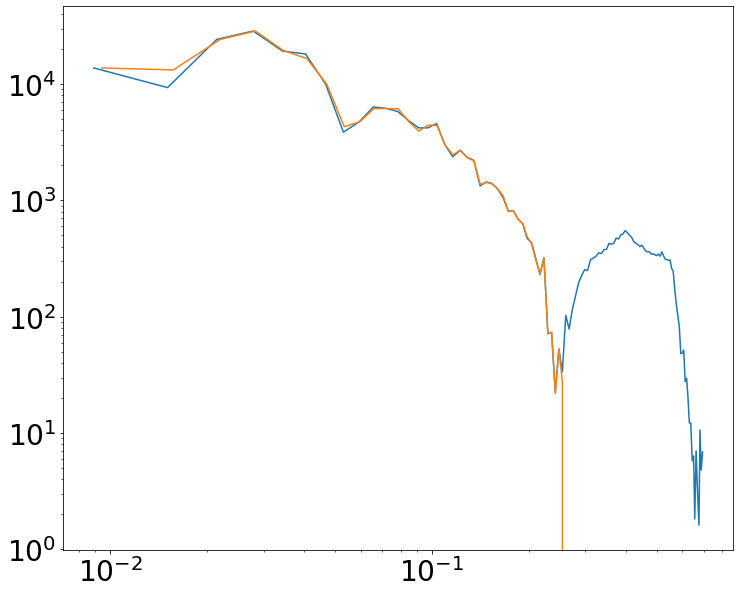

In [741]:
#pylians comparison
plt.figure(figsize=(12,10))
plt.loglog(k_py,np.abs(Pk2))
plt.loglog(k_est,pk['PP']['l=2,t=0'][2].real)

In [ ]:
#%%time
t=0.5
import cProfile
cProfile.run('Pk.Pk(field_tmp,L,Nside,l,k,grid_info,binning_info, t,iFFT,dtype,threads,rfft,verbose)')

In [19]:
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var

In [526]:
with open('../../mathematica_output.txt') as file:
    string1 = file.read()
    string1 = string1.replace('\n','').replace('  ','')#.replace('Sqrt[pi]','(np.pi)**(1/2)')
#print(string1.replace(". ", "").replace("\n", "").replace("\\", "").replace("x", "d").replace("kd^2", "(k*d**2)"))#.replace("k", "k[i]"))

#change multiplication and 
python_mathematica = mathematica(string1)
ppp = str(python_mathematica).replace('*I*','*1j*').replace('sqrt(','np.sqrt(').replace('pi','np.pi').replace('e**(','np.exp(').replace('erfunccc','scipy.special.erf((sigma*kk)/np.sqrt(2))').replace('erfunc','scipy.special.erf(sigma*kk)').replace('e**(','np.exp(').replace('atan','np.arctan')
print(ppp)

Pks*(2*b1**2*kk**5*sigma**5 + 24*f**2*kk*sigma + 8*f*kk**3*sigma**3*(-b1 + f) + np.sqrt(2)*(kk**2*sigma**2 + 2)*(b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 - 12*f**2)*np.arctan(np.sqrt(2)*kk*sigma/2))/(2*kk**5*sigma**5*(kk**2*sigma**2 + 2))


In [159]:
from classy import Class
z= 0
#Start by specifying the cosmology - fiducial quijote...
Omega_b = 0.049#0.05
Omega_m = 0.3175
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.6711#0.7 #H0/100
A_s = 2.1e-9
n_s = 0.9624
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}
#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=50000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [160]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)

<built-in method get_current_derived_parameters of classy.Class object at 0x55be9f45b350>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [171]:
#%%time
z= 0.0
print(z)
#ok so set a comoving distance of observation
d = comoving_dist(z)
if d == 0:
    d=np.sqrt(250**2 + 250**2 + 250**2)
print(d)
#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
     
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    return Pk,Pk_d,Pk_dd

#so set parameters...
Pk_,Pk_d,Pk_dd = get_pkinfo_z(k,z)


ks = np.geomspace(1e-3,4e-1,100)
f = f_intp(z)

Pks = Pk_(ks)
Pkd= Pk_d(ks)
Pkdd= Pk_dd(ks)

d=1000
b1 = 1
t=0

0.0
433.0127018922193


In [231]:
Pk_l0_wa = f*(Pks*(7*b1*(-25*s - t*(12*t - 12) + 4) + f*(175*s - t*(36*t - 36) - 68)) + ks*(Pkd*(-35*b1*(5*s + t*(4*t - 4)) + f*(175*s - t*(60*t - 60) - 48)) - 2*Pkdd*ks*(7*b1*(t*(2*t - 2) + 1) + f*(t*(6*t - 6) - 5))))/(105*d**2*ks**2)
Pk_l1_wa = -4*f*(3*Pks+ Pkd*ks)*(7*b1 + 3*f)*(2*t - 1)/(35*d*ks)
Pk_l2_wa = 2*f*(-Pks*(2*b1*(70*s + t*(66*t - 66) + 5) + f*(-35*s + t*(108*t - 108) + 40)) + ks*(Pkd*(b1*(70*s + t*(44*t - 44) - 6) + f*(35*s - t*(12*t - 12) - 6)) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)
Pk_l3_wa = -4*1j*f*(2*t - 1)*(Pkd*ks*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*ks)

def pk_oct(ks,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -4*1j*f*(2*t - 1)*(Pkd*ks*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*ks)

Pl0_pp = b1**2 *Pks+ (2*b1*f*Pks)/3 + (f**2 *Pks)/5
Pl2_pp = (4*b1*f*Pks)/3 + (4*f**2 *Pks)/7
Pl4_pp = (8*f**2 *Pks)/35

In [36]:
#these are some multipoles without inverse distance terms
Pk_l0_wa1 = 2*f*(Pks*(-21*b1*(t*(2*t - 2) + 1) - 18*f*t*(t - 1) + f) + ks*(Pkd*(-35*b1*(t*(2*t - 2) + 1) + f*(-t*(30*t - 30) + 11)) + Pkdd*ks*(-7*b1*(t*(2*t - 2) + 1) + f*(-t*(6*t - 6) + 5))))/(105*d**2*ks**2)
Pk_l2_wa1 = 2*f*(-2*Pks*(33*b1*(t*(2*t - 2) + 1) + f*(t*(54*t - 54) + 13)) + ks*(2*Pkd*(22*b1*t*(t - 1) + 11*b1 - 6*f*t*(t - 1) + 4*f) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)


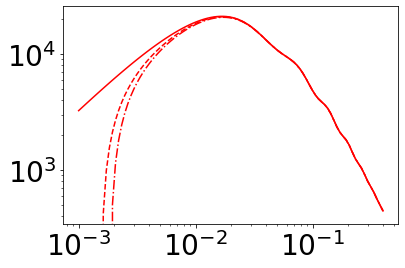

In [126]:
#plt.loglog(ks,Pl0_pp,color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa1,'-.',color='blue')
plt.loglog(ks,Pl2_pp,color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa,'--',color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa1,'-.',color='red')
#plt.loglog(ks,Pk_l1_wa)

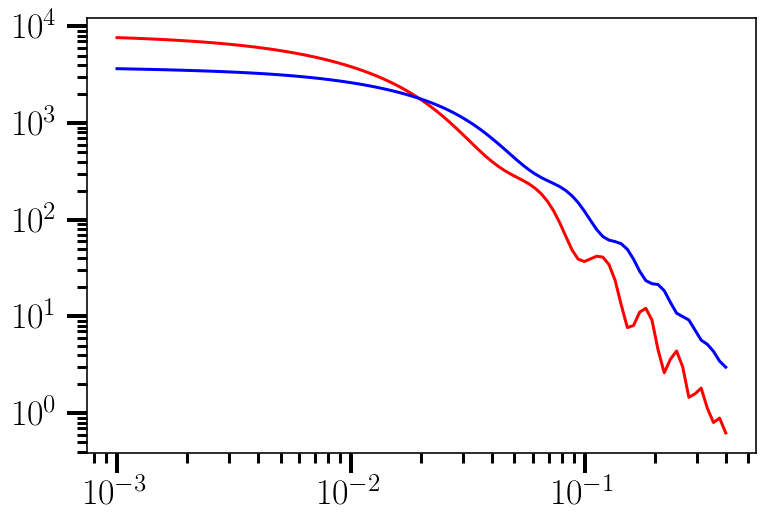

In [42]:
plt.plot(ks,Pk_l1_wa,color='red')
plt.plot(ks,-Pk_l3_wa.imag,color='blue')
plt.xscale('log')
plt.yscale('log')

In [47]:
import scipy 

In [128]:
#all quadrupole
#PP with dfog
def pk_dfog(ks,sigma):
    Pks= Pk_(ks)
    return 5*Pks*np.exp(-ks**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(8*b1**2*ks**6*sigma**6 + 4*b1*ks**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*ks**2*sigma**2*(-6*b1 + f)) - 90*f**2*ks*sigma - 24*f*ks**3*sigma**3*(3*b1 + 2*f) - ks**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*ks**7*sigma**7)

#include all terms!!
def full_dfog_inv(ks,sigma,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return -5*np.exp(-ks**2*sigma**2)*(-8*Pks*(-8*b1**2*ks**9*sigma**7*(6*d**2 + sigma**2*(4*ks**2*sigma**2 - t**2*(16*ks**2*sigma**2 + 24) + t*(16*ks**2*sigma**2 + 24) + 15)) + 4*b1*f*ks**3*sigma**3*(-16*ks**8*sigma**8 - 16*ks**6*sigma**4*(d**2 + sigma**2*(7 - 5*s)) - 4*ks**4*(9*d**2*sigma**2 + sigma**4*(73 - 70*s)) + 15*ks**2*sigma**2*(24*s - 35) + t**2*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) - t*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**8*sigma**6*(d**2*(-4*ks**2*sigma**2 + 6) + 3*sigma**2*(-2*ks**2*sigma**2 - 8*t**2 + 8*t + 5)) - 2*b1*f*ks**2*sigma**2*(8*d**2*ks**6*sigma**4 + ks**4*(-36*d**2*sigma**2 + sigma**4*(40*s - 22)) + 45*ks**2*sigma**2*(8*s - 5) - t**2*(792*ks**2*sigma**2 - 5400) + t*(792*ks**2*sigma**2 - 5400) - 450) + f**2*(-2*ks**6*(6*d**2*sigma**4 + sigma**6*(100*s**2 - 120*s + 39)) + 9*ks**4*(10*d**2*sigma**2 + sigma**4*(100*s**2 - 160*s + 81)) - 2385*ks**2*sigma**2 - t**2*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + t*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + 12285)) - 2*f**2*ks*sigma*(16*ks**10*sigma**10 + 16*ks**8*sigma**6*(d**2 + sigma**2*(11 - 10*s)) + ks**6*(48*d**2*sigma**4 + sigma**6*(400*s**2 - 720*s + 708)) + 15*ks**4*(6*d**2*sigma**2 + sigma**4*(60*s**2 - 96*s + 161)) + 5805*ks**2*sigma**2 - t**2*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + t*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + 12285)) + ks*(Pkd*(8*b1**2*ks**5*sigma**5*(-24*ks**4*sigma**4 - 138*ks**2*sigma**2 + t**2*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - t*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - 45) + 8*b1*f*ks**3*sigma**3*(-96*ks**6*sigma**6 + 40*ks**4*sigma**4*(2*s - 9) + 6*ks**2*sigma**2*(120*s - 191) + t**2*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - t*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(12*b1**2*ks**4*sigma**4*(16*ks**6*sigma**6 - 20*ks**4*sigma**4 + 36*ks**2*sigma**2 + t**2*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) - t*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) + 15) - 4*b1*f*ks**2*sigma**2*(16*ks**6*sigma**6*(10*s - 3) + 4*ks**4*sigma**4*(51 - 100*s) + 36*ks**2*sigma**2*(20*s - 11) + t**2*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - t*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - 1125) + f**2*(80*ks**6*sigma**6*(4*s - 3) - 36*ks**4*sigma**4*(40*s - 59) - 10620*ks**2*sigma**2 - t**2*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + t*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + 36855)) + 2*f**2*ks*sigma*(-192*ks**8*sigma**8 + 128*ks**6*sigma**6*(5*s - 9) + 24*ks**4*sigma**4*(60*s - 203) - 13950*ks**2*sigma**2 + t**2*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - t*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - 36855)) + Pkdd*ks*(8*b1**2*ks**5*sigma**5*(4*ks**4*sigma**4 + 12*ks**2*sigma**2 + t**2*(24*ks**2*sigma**2 - 540) + t*(-24*ks**2*sigma**2 + 540) + 45) - 8*b1*f*ks**3*sigma**3*(-28*ks**4*sigma**4 - 96*ks**2*sigma**2 + t**2*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - t*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**4*sigma**4*(8*ks**6*sigma**6 - 4*ks**4*sigma**4 + 18*ks**2*sigma**2 + t**2*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - t*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - 45) - 4*b1*f*ks**2*sigma**2*(8*ks**6*sigma**6 + 4*ks**4*sigma**4 - 54*ks**2*sigma**2 - t**2*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + t*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + 225) + f**2*(56*ks**6*sigma**6 - 492*ks**4*sigma**4 + 1950*ks**2*sigma**2 + t**2*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - t*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - 4095)) + 2*f**2*ks*sigma*(64*ks**6*sigma**6 + 284*ks**4*sigma**4 + 780*ks**2*sigma**2 - t**2*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + t*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + 4095))))/(512*d**2*ks**11*sigma**9)

#include no inverse dist stuff
def wa_dfog(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return -5*np.exp(-ks**2*sigma**2)*(-8*Pks*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**8*sigma**6*(d**2*(-4*ks**2*sigma**2 + 6) + 3*sigma**2*(-2*ks**2*sigma**2 - 8*t**2 + 8*t + 5)) - 2*b1*f*ks**2*sigma**2*(8*d**2*ks**6*sigma**4 - 6*ks**4*(6*d**2*sigma**2 + sigma**4) - 81*ks**2*sigma**2 - t**2*(792*ks**2*sigma**2 - 5400) + t*(792*ks**2*sigma**2 - 5400) - 450) + f**2*(-2*ks**6*(6*d**2*sigma**4 + 7*sigma**6) + 9*ks**4*(10*d**2*sigma**2 + 33*sigma**4) - 2385*ks**2*sigma**2 - t**2*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + t*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + 12285)) - 2*ks*sigma*(4*b1**2*ks**8*sigma**6*(6*d**2 + sigma**2*(4*ks**2*sigma**2 - t**2*(16*ks**2*sigma**2 + 24) + t*(16*ks**2*sigma**2 + 24) + 15)) + 2*b1*f*ks**2*sigma**2*(16*ks**8*sigma**8 + 16*ks**6*sigma**4*(d**2 + 5*sigma**2) + 36*ks**4*sigma**2*(d**2 + 5*sigma**2) + 381*ks**2*sigma**2 - t**2*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) + t*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) + 450) + f**2*(16*ks**10*sigma**10 + 16*ks**8*sigma**6*(d**2 + 7*sigma**2) + ks**6*(48*d**2*sigma**4 + 484*sigma**6) + 3*ks**4*(30*d**2*sigma**2 + 661*sigma**4) + 5805*ks**2*sigma**2 - t**2*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + t*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + 12285))) + ks*(Pkd*(8*b1**2*ks**5*sigma**5*(-24*ks**4*sigma**4 - 138*ks**2*sigma**2 + t**2*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - t*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - 45) + 8*b1*f*ks**3*sigma**3*(-96*ks**6*sigma**6 - 328*ks**4*sigma**4 - 858*ks**2*sigma**2 + t**2*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - t*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(12*b1**2*ks**4*sigma**4*(16*ks**6*sigma**6 - 20*ks**4*sigma**4 + 36*ks**2*sigma**2 + t**2*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) - t*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) + 15) - 4*b1*f*ks**2*sigma**2*(16*ks**6*sigma**6 + 44*ks**4*sigma**4 - 108*ks**2*sigma**2 + t**2*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - t*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - 1125) + f**2*(-112*ks**6*sigma**6 + 1548*ks**4*sigma**4 - 10620*ks**2*sigma**2 - t**2*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + t*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + 36855)) + 2*f**2*ks*sigma*(-192*ks**8*sigma**8 - 896*ks**6*sigma**6 - 4296*ks**4*sigma**4 - 13950*ks**2*sigma**2 + t**2*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - t*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - 36855)) + Pkdd*ks*(8*b1**2*ks**5*sigma**5*(4*ks**4*sigma**4 + 12*ks**2*sigma**2 + t**2*(24*ks**2*sigma**2 - 540) + t*(-24*ks**2*sigma**2 + 540) + 45) - 8*b1*f*ks**3*sigma**3*(-28*ks**4*sigma**4 - 96*ks**2*sigma**2 + t**2*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - t*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**4*sigma**4*(8*ks**6*sigma**6 - 4*ks**4*sigma**4 + 18*ks**2*sigma**2 + t**2*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - t*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - 45) - 4*b1*f*ks**2*sigma**2*(8*ks**6*sigma**6 + 4*ks**4*sigma**4 - 54*ks**2*sigma**2 - t**2*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + t*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + 225) + f**2*(56*ks**6*sigma**6 - 492*ks**4*sigma**4 + 1950*ks**2*sigma**2 + t**2*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - t*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - 4095)) + 2*f**2*ks*sigma*(64*ks**6*sigma**6 + 284*ks**4*sigma**4 + 780*ks**2*sigma**2 - t**2*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + t*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + 4095))))/(512*d**2*ks**11*sigma**9)

#fake fog with no wide ange mixing
def wa_dfog_fake(ks,sigma,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return 5*np.exp(-ks**2*sigma**2)*(Pks*(-24*b1**2*d**2*ks**9*sigma**7 - 8*b1*f*ks**3*sigma**3*(4*d**2*ks**6*sigma**4 + ks**4*(9*d**2*sigma**2 - 28*sigma**4) - 111*ks**2*sigma**2 - t**2*(56*ks**4*sigma**4 + 222*ks**2*sigma**2 + 720) + t*(56*ks**4*sigma**4 + 222*ks**2*sigma**2 + 720) - 360) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*d**2*ks**8*sigma**6*(-2*ks**2*sigma**2 + 3) - 4*b1*f*ks**2*sigma**2*(2*d**2*ks**6*sigma**4 - 9*ks**4*sigma**2*(d**2 - 2*sigma**2) - 129*ks**2*sigma**2 + t**2*(36*ks**4*sigma**4 - 258*ks**2*sigma**2 + 720) - t*(36*ks**4*sigma**4 - 258*ks**2*sigma**2 + 720) + 360) + f**2*(ks**6*(-6*d**2*sigma**4 + 56*sigma**6) + ks**4*(45*d**2*sigma**2 - 804*sigma**4) + 5580*ks**2*sigma**2 + t**2*(144*ks**6*sigma**6 - 2232*ks**4*sigma**4 + 16200*ks**2*sigma**2 - 45360) - t*(144*ks**6*sigma**6 - 2232*ks**4*sigma**4 + 16200*ks**2*sigma**2 - 45360) - 15120)) + 2*f**2*ks*sigma*(-8*d**2*ks**8*sigma**6 - 24*ks**6*sigma**4*(d**2 - 6*sigma**2) - 9*ks**4*(5*d**2*sigma**2 - 124*sigma**4) + 4500*ks**2*sigma**2 + t**2*(480*ks**6*sigma**6 + 3528*ks**4*sigma**4 + 14040*ks**2*sigma**2 + 45360) - t*(480*ks**6*sigma**6 + 3528*ks**4*sigma**4 + 14040*ks**2*sigma**2 + 45360) + 15120)) + f*ks*(-2*Pkd*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(-2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(14*ks**4*sigma**4 - 93*ks**2*sigma**2 + 225) + f*(16*ks**6*sigma**6 - 186*ks**4*sigma**4 + 1125*ks**2*sigma**2 + t**2*(48*ks**6*sigma**6 - 576*ks**4*sigma**4 + 3510*ks**2*sigma**2 - 8505) + t*(-48*ks**6*sigma**6 + 576*ks**4*sigma**4 - 3510*ks**2*sigma**2 + 8505) - 2835)) + 6*ks*sigma*(2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(4*ks**4*sigma**4 + 19*ks**2*sigma**2 + 75) + f*(8*ks**6*sigma**6 + 64*ks**4*sigma**4 + 255*ks**2*sigma**2 + t**2*(16*ks**6*sigma**6 + 168*ks**4*sigma**4 + 720*ks**2*sigma**2 + 2835) - t*(16*ks**6*sigma**6 + 168*ks**4*sigma**4 + 720*ks**2*sigma**2 + 2835) + 945))) + Pkdd*ks*(4*b1*ks**3*sigma**3*(2*t**2 - 2*t + 1)*(2*ks**4*sigma**4 + 3*ks**2*sigma**2 + 90) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(4*ks**6*sigma**6 - 16*ks**4*sigma**4 + 57*ks**2*sigma**2 - 90) + f*(4*ks**6*sigma**6 - 48*ks**4*sigma**4 + 285*ks**2*sigma**2 + t**2*(24*ks**6*sigma**6 - 216*ks**4*sigma**4 + 990*ks**2*sigma**2 - 1890) - t*(24*ks**6*sigma**6 - 216*ks**4*sigma**4 + 990*ks**2*sigma**2 - 1890) - 630)) + 2*f*ks*sigma*(26*ks**4*sigma**4 + 135*ks**2*sigma**2 + t**2*(60*ks**4*sigma**4 + 270*ks**2*sigma**2 + 1890) - t*(60*ks**4*sigma**4 + 270*ks**2*sigma**2 + 1890) + 630))))/(32*d**2*ks**11*sigma**9)


#not sure what these two are...
def wainv_dfog(ks,sigma):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -5*f*(5*s - 2)*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(4*Pks*(9*b1 + 9*f + ks**2*sigma**2*(b1 - f)) + Pkd*ks*(-4*b1*ks**4*sigma**4 - 18*b1 - 9*f + ks**2*sigma**2*(10*b1 + 2*f))) + 2*np.exp(-ks**2*sigma**2)*ks*sigma*(-4*Pks*(9*b1 + 9*f + ks**4*sigma**4*(2*b1 + 2*f) + ks**2*sigma**2*(7*b1 + 5*f)) + Pkd*ks*(18*b1 + 9*f + ks**2*sigma**2*(2*b1 + 4*f))))/(16*d**2*ks**7*sigma**5)

def inv_dfog(ks,sigma):
    Pks= Pk_(ks)
    return 5*Pks*f**2*(2 - 5*s)**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(-2*ks**2*sigma**2 + 9) - 2*np.exp(-ks**2*sigma**2)*ks*sigma*(4*ks**2*sigma**2 + 9))/(16*d**2*ks**7*sigma**5)


In [45]:
#dipole stuff 
#include all terms!!
def dip_dfog(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return 3*1j*np.exp(-ks**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(Pkd*ks*(-8*b1**2*ks**6*sigma**6 + 4*b1*ks**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*ks**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*ks**6*sigma**6 + 45*f**2 - 3*f*ks**2*sigma**2*(-6*b1 + f))) + 2*ks*sigma*(-Pkd*ks*(45*f**2 + 12*f*ks**2*sigma**2*(3*b1 + 2*f) + ks**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*ks**4*sigma**4*(6*b1 + 5*f) + 9*f*ks**2*sigma**2*(2*b1 + 3*f) + 4*ks**6*sigma**6*(b1 + f)**2)))/(32*d*ks**8*sigma**7)

#fake fog
def dip_dfog_fake(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -3*1j*np.exp(-ks**2*sigma**2)*f*(2*t - 1)*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(Pkd*ks*(-4*b1*ks**4*sigma**4 + 15*f + ks**2*sigma**2*(6*b1 - 6*f)) + 12*Pks*(-5*f + ks**2*sigma**2*(-b1 + f))) + 2*ks*sigma*(-Pkd*ks*(15*f + ks**2*sigma**2*(6*b1 + 4*f)) + 4*Pks*(15*f + ks**4*sigma**4*(2*b1 + 2*f) + ks**2*sigma**2*(3*b1 + 7*f))))/(8*d*ks**8*sigma**7)




In [529]:
def pk_mono_dfog1_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    return (2*Pks*(6*b1**2*kk**9*sigma**9*(3*kk**4*sigma**4 + 16*kk**2*sigma**2 + 64*t**2 - 64*t + 20) - 16*b1*f*kk**3*sigma**3*(33*kk**6*sigma**6 + 232*kk**4*sigma**4 + 524*kk**2*sigma**2 + t**2*(72*kk**6*sigma**6 + 960*kk**4*sigma**4 + 2304*kk**2*sigma**2 + 1728) - t*(72*kk**6*sigma**6 + 960*kk**4*sigma**4 + 2304*kk**2*sigma**2 + 1728) + 384) + 8*f**2*kk*sigma*(3*kk**8*sigma**8 + 604*kk**6*sigma**6 + 3860*kk**4*sigma**4 + 8208*kk**2*sigma**2 + t**2*(1296*kk**6*sigma**6 + 10272*kk**4*sigma**4 + 23616*kk**2*sigma**2 + 17280) - t*(1296*kk**6*sigma**6 + 10272*kk**4*sigma**4 + 23616*kk**2*sigma**2 + 17280) + 5760) + 3*np.sqrt(2)*(kk**2*sigma**2 + 2)**3*(3*b1**2*kk**8*sigma**8 + 8*b1*f*kk**2*sigma**2*(kk**2*sigma**2 + 144*t**2 - 144*t + 32) - 4*f**2*(-kk**4*sigma**4 + 44*kk**2*sigma**2 + t**2*(48*kk**2*sigma**2 + 1440) - t*(48*kk**2*sigma**2 + 1440) + 480))*np.arctan(np.sqrt(2)*kk*sigma/2)) + kk*(-2*Pkd*(-2*b1**2*kk**5*sigma**5*(9*kk**6*sigma**6 + 24*kk**4*sigma**4 + 32*kk**2*sigma**2 + t**2*(18*kk**4*sigma**4 - 96*kk**2*sigma**2 - 72) + t*(-18*kk**4*sigma**4 + 96*kk**2*sigma**2 + 72) + 24) + 8*b1*f*kk**3*sigma**3*(3*kk**6*sigma**6 - 50*kk**4*sigma**4 - 224*kk**2*sigma**2 - t**2*(138*kk**4*sigma**4 + 912*kk**2*sigma**2 + 1080) + t*(138*kk**4*sigma**4 + 912*kk**2*sigma**2 + 1080) - 240) + 8*f**2*kk*sigma*(3*kk**6*sigma**6 + 268*kk**4*sigma**4 + 1056*kk**2*sigma**2 + t**2*(582*kk**4*sigma**4 + 2880*kk**2*sigma**2 + 3240) - t*(582*kk**4*sigma**4 + 2880*kk**2*sigma**2 + 3240) + 1080) - 3*np.sqrt(2)*(kk**2*sigma**2 + 2)**2*(b1**2*kk**4*sigma**4*(3*kk**4*sigma**4 - 2*kk**2*sigma**2 + t**2*(6*kk**2*sigma**2 + 12) - t*(6*kk**2*sigma**2 + 12) - 4) - 4*b1*f*kk**2*sigma**2*(kk**4*sigma**4 + 4*kk**2*sigma**2 + t**2*(2*kk**2*sigma**2 + 180) - t*(2*kk**2*sigma**2 + 180) + 40) + 4*f**2*(-kk**4*sigma**4 + 26*kk**2*sigma**2 + t**2*(30*kk**2*sigma**2 + 540) - t*(30*kk**2*sigma**2 + 540) + 180))*np.arctan(np.sqrt(2)*kk*sigma/2)) + Pkdd*kk*(kk**2*sigma**2 + 2)*(b1*kk**2*sigma**2 - 2*f)*(2*b1*kk**3*sigma**3*(3*kk**4*sigma**4 - 2*kk**2*sigma**2 + t**2*(12*kk**2*sigma**2 + 72) - t*(12*kk**2*sigma**2 + 72) - 24) - 4*f*kk*sigma*(3*kk**4*sigma**4 + 70*kk**2*sigma**2 + t**2*(156*kk**2*sigma**2 + 360) - t*(156*kk**2*sigma**2 + 360) + 120) + 3*np.sqrt(2)*(kk**2*sigma**2 + 2)*(b1*kk**2*sigma**2*(kk**4*sigma**4 - 2*kk**2*sigma**2 + t**2*(4*kk**2*sigma**2 - 24) - t*(4*kk**2*sigma**2 - 24) + 8) + f*(-2*kk**4*sigma**4 + 20*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 + 240) - t*(24*kk**2*sigma**2 + 240) + 80))*np.arctan(np.sqrt(2)*kk*sigma/2)))*(kk**2*sigma**2 + 2))/(48*d**2*kk**9*sigma**7*(kk**2*sigma**2 + 2)**3)

def pk_mono_dfog1(kk,sigma):
    Pks = Pk_(kk)
    return Pks*(2*b1**2*kk**5*sigma**5 + 24*f**2*kk*sigma + 8*f*kk**3*sigma**3*(-b1 + f) + np.sqrt(2)*(kk**2*sigma**2 + 2)*(b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 - 12*f**2)*np.arctan(np.sqrt(2)*kk*sigma/2))/(2*kk**5*sigma**5*(kk**2*sigma**2 + 2))


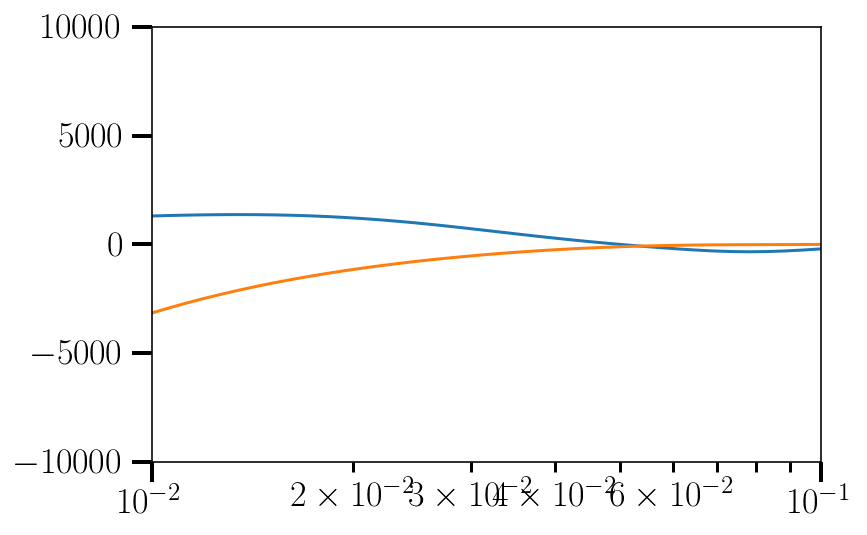

In [530]:
#PP functions with Dfog
def pk_mono_dfog(kk,sigma):
    Pks = Pk_(kk)
    return Pks*np.exp(-kk**2*sigma**2)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2) - 6*f**2*kk*sigma - 4*f*kk**3*sigma**3*(2*b1 + f))/(8*kk**5*sigma**5)  
    
def pk_mono_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(4*t**2 - 4*t - 1) + 4*b1*f*kk**3*sigma**3*(-4*kk**6*sigma**6 - 14*kk**4*sigma**4 - 33*kk**2*sigma**2 + t**2*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - t*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - 54) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8 - 6*b1*f*kk**2*sigma**2*(kk**2*sigma**2 + 24*t**2 - 24*t - 18) + f**2*(7*kk**4*sigma**4 - 153*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 765)) + 2*f**2*kk*sigma*(-4*kk**8*sigma**8 - 22*kk**6*sigma**6 - 109*kk**4*sigma**4 - 357*kk**2*sigma**2 + t**2*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - t*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - 765)) + kk*(Pkd*(-8*b1**2*kk**5*sigma**5*(8*kk**2*sigma**2 + 3)*(4*t**2 - 4*t - 3) + 8*b1*f*kk**3*sigma**3*(24*kk**4*sigma**4 + 76*kk**2*sigma**2 - t**2*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + t*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + 135) - np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(8*kk**4*sigma**4 - 6*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 + 4) - t*(8*kk**2*sigma**2 + 4) - 3) + 4*b1*f*kk**2*sigma**2*(8*kk**4*sigma**4 - 14*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 180) + t*(-8*kk**2*sigma**2 + 180) + 135) + f**2*(56*kk**4*sigma**4 - 666*kk**2*sigma**2 + t**2*(120*kk**2*sigma**2 - 1620) - t*(120*kk**2*sigma**2 - 1620) + 2295)) + 2*f**2*kk*sigma*(48*kk**6*sigma**6 + 224*kk**4*sigma**4 + 864*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + t*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + 2295)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(2*kk**2*sigma**2 + 12*t**2 - 12*t - 9) + 8*b1*f*kk**3*sigma**3*(-10*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 36) - t*(16*kk**2*sigma**2 + 36) - 27) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(4*kk**4*sigma**4 - 8*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 12) + t*(-8*kk**2*sigma**2 + 12) + 9) - 4*b1*f*kk**2*sigma**2*(4*kk**4*sigma**4 + 8*kk**2*sigma**2 + t**2*(-8*kk**2*sigma**2 + 36) + t*(8*kk**2*sigma**2 - 36) - 27) + f**2*(28*kk**4*sigma**4 - 120*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 180) + t*(-24*kk**2*sigma**2 + 180) + 255)) + 2*f**2*kk*sigma*(-16*kk**4*sigma**4 - 50*kk**2*sigma**2 + t**2*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - t*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - 255))))/(128*d**2*kk**9*sigma**7)

def pk_quad_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  5*Pks*np.exp(-kk**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*kk**2*sigma**2*(-6*b1 + f)) - 90*f**2*kk*sigma - 24*f*kk**3*sigma**3*(3*b1 + 2*f) - kk**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*kk**7*sigma**7)

def pk_quad_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 5*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-4*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 24) - t*(16*kk**2*sigma**2 + 24) - 15) + 4*b1*f*kk**3*sigma**3*(-16*kk**8*sigma**8 - 80*kk**6*sigma**6 - 180*kk**4*sigma**4 - 381*kk**2*sigma**2 + t**2*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - t*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8*(-2*kk**2*sigma**2 - 8*t**2 + 8*t + 5) + 6*b1*f*kk**2*sigma**2*(2*kk**4*sigma**4 + 27*kk**2*sigma**2 + t**2*(264*kk**2*sigma**2 - 1800) - t*(264*kk**2*sigma**2 - 1800) + 150) + f**2*(-14*kk**6*sigma**6 + 297*kk**4*sigma**4 - 2385*kk**2*sigma**2 - t**2*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + t*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + 12285)) + 2*f**2*kk*sigma*(-16*kk**10*sigma**10 - 112*kk**8*sigma**8 - 484*kk**6*sigma**6 - 1983*kk**4*sigma**4 - 5805*kk**2*sigma**2 + t**2*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - t*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - 12285)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(24*kk**4*sigma**4 + 138*kk**2*sigma**2 - t**2*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + t*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-96*kk**6*sigma**6 - 328*kk**4*sigma**4 - 858*kk**2*sigma**2 + t**2*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - t*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(16*kk**6*sigma**6 - 20*kk**4*sigma**4 + 36*kk**2*sigma**2 + t**2*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) - t*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) + 15) + 4*b1*f*kk**2*sigma**2*(16*kk**6*sigma**6 + 44*kk**4*sigma**4 - 108*kk**2*sigma**2 + t**2*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - t*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - 1125) + f**2*(112*kk**6*sigma**6 - 1548*kk**4*sigma**4 + 10620*kk**2*sigma**2 + t**2*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - t*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - 36855)) + 2*f**2*kk*sigma*(192*kk**8*sigma**8 + 896*kk**6*sigma**6 + 4296*kk**4*sigma**4 + 13950*kk**2*sigma**2 - t**2*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + t*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + 36855)) - Pkdd*kk*(8*b1**2*kk**5*sigma**5*(4*kk**4*sigma**4 + 12*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-28*kk**4*sigma**4 - 96*kk**2*sigma**2 + t**2*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - t*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(8*kk**6*sigma**6 - 4*kk**4*sigma**4 + 18*kk**2*sigma**2 + t**2*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - t*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - 45) - 4*b1*f*kk**2*sigma**2*(8*kk**6*sigma**6 + 4*kk**4*sigma**4 - 54*kk**2*sigma**2 - t**2*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + t*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + 225) + f**2*(56*kk**6*sigma**6 - 492*kk**4*sigma**4 + 1950*kk**2*sigma**2 + t**2*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - t*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - 4095)) + 2*f**2*kk*sigma*(64*kk**6*sigma**6 + 284*kk**4*sigma**4 + 780*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + t*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + 4095))))/(512*d**2*kk**11*sigma**9)

def pk_dipo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return 3*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(Pkd*kk*(-8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*kk**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*kk**6*sigma**6 + 45*f**2 - 3*f*kk**2*sigma**2*(-6*b1 + f))) + 2*kk*sigma*(-Pkd*kk*(45*f**2 + 12*f*kk**2*sigma**2*(3*b1 + 2*f) + kk**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*kk**4*sigma**4*(6*b1 + 5*f) + 9*f*kk**2*sigma**2*(2*b1 + 3*f) + 4*kk**6*sigma**6*(b1 + f)**2)))/(32*d*kk**8*sigma**7)
            
def pk_octo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return  7*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(Pkd*kk*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-4*b1 + f) + 875*f**2 + f*kk**2*sigma**2*(500*b1 - 240*f) + kk**4*sigma**4*(100*b1**2 - 192*b1*f + 12*f**2)) - 5250*f**2*kk*sigma - 20*f*kk**3*sigma**3*(150*b1 + 103*f) - kk**7*sigma**7*(16*b1**2 + 128*b1*f + 64*f**2) - kk**5*sigma**5*(600*b1**2 + 848*b1*f + 512*f**2)) + 4*Pks*(-3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-8*b1**2*kk**8*sigma**8 + 20*b1**2*kk**6*sigma**6 + 875*f**2 + 6*f*kk**4*sigma**4*(-6*b1 + f) + f*kk**2*sigma**2*(250*b1 - 165*f)) + 5250*f**2*kk*sigma + 8*f*kk**5*sigma**5*(98*b1 + 97*f) + 10*f*kk**3*sigma**3*(150*b1 + 251*f) + 32*kk**9*sigma**9*(b1 + f)**2 + kk**7*sigma**7*(120*b1**2 + 256*b1*f + 160*f**2)))/(128*d*kk**10*sigma**9)

def pk_hexa_dfog1(kk,sigma):
    Pks = Pk_(kk)
    return (8*f**2 *Pks)/35

def pk_hexa_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  9*Pks*np.exp(-kk**2*sigma**2)*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-5*b1 + f) + 1225*f**2 + f*kk**2*sigma**2*(700*b1 - 300*f) + kk**4*sigma**4*(140*b1**2 - 240*b1*f + 12*f**2)) - 7350*f**2*kk*sigma - 100*f*kk**3*sigma**3*(42*b1 + 31*f) - kk**7*sigma**7*(80*b1**2 + 256*b1*f + 128*f**2) - kk**5*sigma**5*(840*b1**2 + 1360*b1*f + 832*f**2))/(256*kk**9*sigma**9)

#Extra wide-angle contributions...
def pk_hexa_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 9*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-32*kk**4*sigma**4 - 190*kk**2*sigma**2 + t**2*(128*kk**4*sigma**4 + 640*kk**2*sigma**2 + 1680) - t*(128*kk**4*sigma**4 + 640*kk**2*sigma**2 + 1680) - 735) + 4*b1*f*kk**3*sigma**3*(-128*kk**10*sigma**10 - 1088*kk**8*sigma**8 - 3456*kk**6*sigma**6 - 6898*kk**4*sigma**4 - 1325*kk**2*sigma**2 + t**2*(512*kk**10*sigma**10 + 3072*kk**8*sigma**8 + 25216*kk**6*sigma**6 + 132224*kk**4*sigma**4 + 452000*kk**2*sigma**2 + 1029000) - t*(512*kk**10*sigma**10 + 3072*kk**8*sigma**8 + 25216*kk**6*sigma**6 + 132224*kk**4*sigma**4 + 452000*kk**2*sigma**2 + 1029000) + 51450) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**8*sigma**8*(12*kk**4*sigma**4 - 100*kk**2*sigma**2 + t**2*(160*kk**2*sigma**2 - 560) - t*(160*kk**2*sigma**2 - 560) + 245) - 2*b1*f*kk**2*sigma**2*(12*kk**6*sigma**6 + 1044*kk**4*sigma**4 - 11875*kk**2*sigma**2 + t**2*(4608*kk**4*sigma**4 - 78000*kk**2*sigma**2 + 343000) - t*(4608*kk**4*sigma**4 - 78000*kk**2*sigma**2 + 343000) + 17150) + f**2*(28*kk**8*sigma**8 - 552*kk**6*sigma**6 + 185*kk**4*sigma**4 + 22225*kk**2*sigma**2 + t**2*(1536*kk**6*sigma**6 - 84960*kk**4*sigma**4 + 1113000*kk**2*sigma**2 - 4630500) - t*(1536*kk**6*sigma**6 - 84960*kk**4*sigma**4 + 1113000*kk**2*sigma**2 - 4630500) + 33075)) + 2*f**2*kk*sigma*(-128*kk**12*sigma**12 - 1344*kk**10*sigma**10 - 5888*kk**8*sigma**8 - 24054*kk**6*sigma**6 - 71465*kk**4*sigma**4 - 132825*kk**2*sigma**2 + t**2*(512*kk**12*sigma**12 + 3584*kk**10*sigma**10 + 45696*kk**8*sigma**8 + 333312*kk**6*sigma**6 + 1733280*kk**4*sigma**4 + 5922000*kk**2*sigma**2 + 13891500) - t*(512*kk**12*sigma**12 + 3584*kk**10*sigma**10 + 45696*kk**8*sigma**8 + 333312*kk**6*sigma**6 + 1733280*kk**4*sigma**4 + 5922000*kk**2*sigma**2 + 13891500) - 99225)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(528*kk**6*sigma**6 + 348*kk**4*sigma**4 + 1900*kk**2*sigma**2 - t**2*(1024*kk**6*sigma**6 + 14704*kk**4*sigma**4 + 101200*kk**2*sigma**2 + 73500) + t*(1024*kk**6*sigma**6 + 14704*kk**4*sigma**4 + 101200*kk**2*sigma**2 + 73500) - 3675) - 8*b1*f*kk**3*sigma**3*(-768*kk**8*sigma**8 - 2512*kk**6*sigma**6 - 5660*kk**4*sigma**4 - 2000*kk**2*sigma**2 + t**2*(2048*kk**8*sigma**8 + 39424*kk**6*sigma**6 + 261680*kk**4*sigma**4 + 1004000*kk**2*sigma**2 + 2572500) - t*(2048*kk**8*sigma**8 + 39424*kk**6*sigma**6 + 261680*kk**4*sigma**4 + 1004000*kk**2*sigma**2 + 2572500) + 128625) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-4*b1**2*kk**4*sigma**4*(96*kk**8*sigma**8 - 232*kk**6*sigma**6 + 524*kk**4*sigma**4 - 1450*kk**2*sigma**2 + t**2*(2656*kk**6*sigma**6 - 13232*kk**4*sigma**4 + 17400*kk**2*sigma**2 + 24500) - t*(2656*kk**6*sigma**6 - 13232*kk**4*sigma**4 + 17400*kk**2*sigma**2 + 24500) + 1225) + 4*b1*f*kk**2*sigma**2*(32*kk**8*sigma**8 + 424*kk**6*sigma**6 - 6180*kk**4*sigma**4 + 29250*kk**2*sigma**2 + t**2*(32*kk**6*sigma**6 - 16560*kk**4*sigma**4 + 237000*kk**2*sigma**2 - 857500) - t*(32*kk**6*sigma**6 - 16560*kk**4*sigma**4 + 237000*kk**2*sigma**2 - 857500) - 42875) + f**2*(224*kk**8*sigma**8 - 4104*kk**6*sigma**6 + 14380*kk**4*sigma**4 - 8050*kk**2*sigma**2 + t**2*(8160*kk**6*sigma**6 - 364080*kk**4*sigma**4 + 3927000*kk**2*sigma**2 - 13891500) - t*(8160*kk**6*sigma**6 - 364080*kk**4*sigma**4 + 3927000*kk**2*sigma**2 - 13891500) + 99225)) + 2*f**2*kk*sigma*(1536*kk**10*sigma**10 + 7168*kk**8*sigma**8 + 32688*kk**6*sigma**6 + 106420*kk**4*sigma**4 + 174300*kk**2*sigma**2 - t**2*(4096*kk**10*sigma**10 + 82944*kk**8*sigma**8 + 737280*kk**6*sigma**6 + 4351440*kk**4*sigma**4 + 16002000*kk**2*sigma**2 + 41674500) + t*(4096*kk**10*sigma**10 + 82944*kk**8*sigma**8 + 737280*kk**6*sigma**6 + 4351440*kk**4*sigma**4 + 16002000*kk**2*sigma**2 + 41674500) + 297675)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(24*kk**6*sigma**6 - 68*kk**4*sigma**4 - 850*kk**2*sigma**2 + t**2*(1264*kk**4*sigma**4 + 400*kk**2*sigma**2 + 73500) - t*(1264*kk**4*sigma**4 + 400*kk**2*sigma**2 + 73500) + 3675) + 8*b1*f*kk**3*sigma**3*(-280*kk**6*sigma**6 - 684*kk**4*sigma**4 + 650*kk**2*sigma**2 + t**2*(512*kk**6*sigma**6 + 17392*kk**4*sigma**4 + 100000*kk**2*sigma**2 + 514500) - t*(512*kk**6*sigma**6 + 17392*kk**4*sigma**4 + 100000*kk**2*sigma**2 + 514500) + 25725) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(16*kk**8*sigma**8 + 48*kk**6*sigma**6 - 384*kk**4*sigma**4 + 1100*kk**2*sigma**2 + t**2*(672*kk**6*sigma**6 - 4688*kk**4*sigma**4 + 16200*kk**2*sigma**2 - 24500) - t*(672*kk**6*sigma**6 - 4688*kk**4*sigma**4 + 16200*kk**2*sigma**2 - 24500) - 1225) - 4*b1*f*kk**2*sigma**2*(16*kk**8*sigma**8 - 48*kk**6*sigma**6 + 1152*kk**4*sigma**4 - 5500*kk**2*sigma**2 - t**2*(672*kk**6*sigma**6 - 14064*kk**4*sigma**4 + 81000*kk**2*sigma**2 - 171500) + t*(672*kk**6*sigma**6 - 14064*kk**4*sigma**4 + 81000*kk**2*sigma**2 - 171500) + 8575) + f**2*(112*kk**8*sigma**8 - 2160*kk**6*sigma**6 + 9920*kk**4*sigma**4 - 17500*kk**2*sigma**2 + t**2*(2016*kk**6*sigma**6 - 70320*kk**4*sigma**4 + 567000*kk**2*sigma**2 - 1543500) - t*(2016*kk**6*sigma**6 - 70320*kk**4*sigma**4 + 567000*kk**2*sigma**2 - 1543500) + 11025)) + 2*f**2*kk*sigma*(-512*kk**8*sigma**8 - 1880*kk**6*sigma**6 - 3580*kk**4*sigma**4 + 30450*kk**2*sigma**2 + t**2*(1024*kk**8*sigma**8 + 33792*kk**6*sigma**6 + 311760*kk**4*sigma**4 + 1386000*kk**2*sigma**2 + 4630500) - t*(1024*kk**8*sigma**8 + 33792*kk**6*sigma**6 + 311760*kk**4*sigma**4 + 1386000*kk**2*sigma**2 + 4630500) - 33075))))/(4096*d**2*kk**13*sigma**11)

def pk_6_dfog(kk,sigma):
    Pks = Pk_(kk)
    return 13*Pks*np.exp(-kk**2*sigma**2)*(-5*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(32*b1**2*kk**10*sigma**10 + 16*b1*kk**8*sigma**8*(-21*b1 + 2*f) - 43659*f**2 + 882*f*kk**2*sigma**2*(-22*b1 + 15*f) + kk**6*sigma**6*(1512*b1**2 - 1008*b1*f + 24*f**2) - kk**4*sigma**4*(2772*b1**2 - 7560*b1*f + 1260*f**2)) - 436590*f**2*kk*sigma - 17640*f*kk**3*sigma**3*(11*b1 + 9*f) - kk**9*sigma**9*(672*b1**2 + 1024*b1*f + 512*f**2) - kk**7*sigma**7*(3360*b1**2 + 11424*b1*f + 6144*f**2) - kk**5*sigma**5*(27720*b1**2 + 53760*b1*f + 40824*f**2))/(1024*kk**11*sigma**11)

#plt.plot(ks,pk_hexa_dfog(ks,10)+pk_hexa_dfog_wa(ks,10,560,0))
plt.plot(ks,pk_hexa_dfog(ks,10))
plt.plot(ks,pk_hexa_dfog_wa(ks,10,560,0))
plt.ylim(-1e+4,1e+4)
plt.xlim(1e-2,1e-1)
plt.xscale('log')


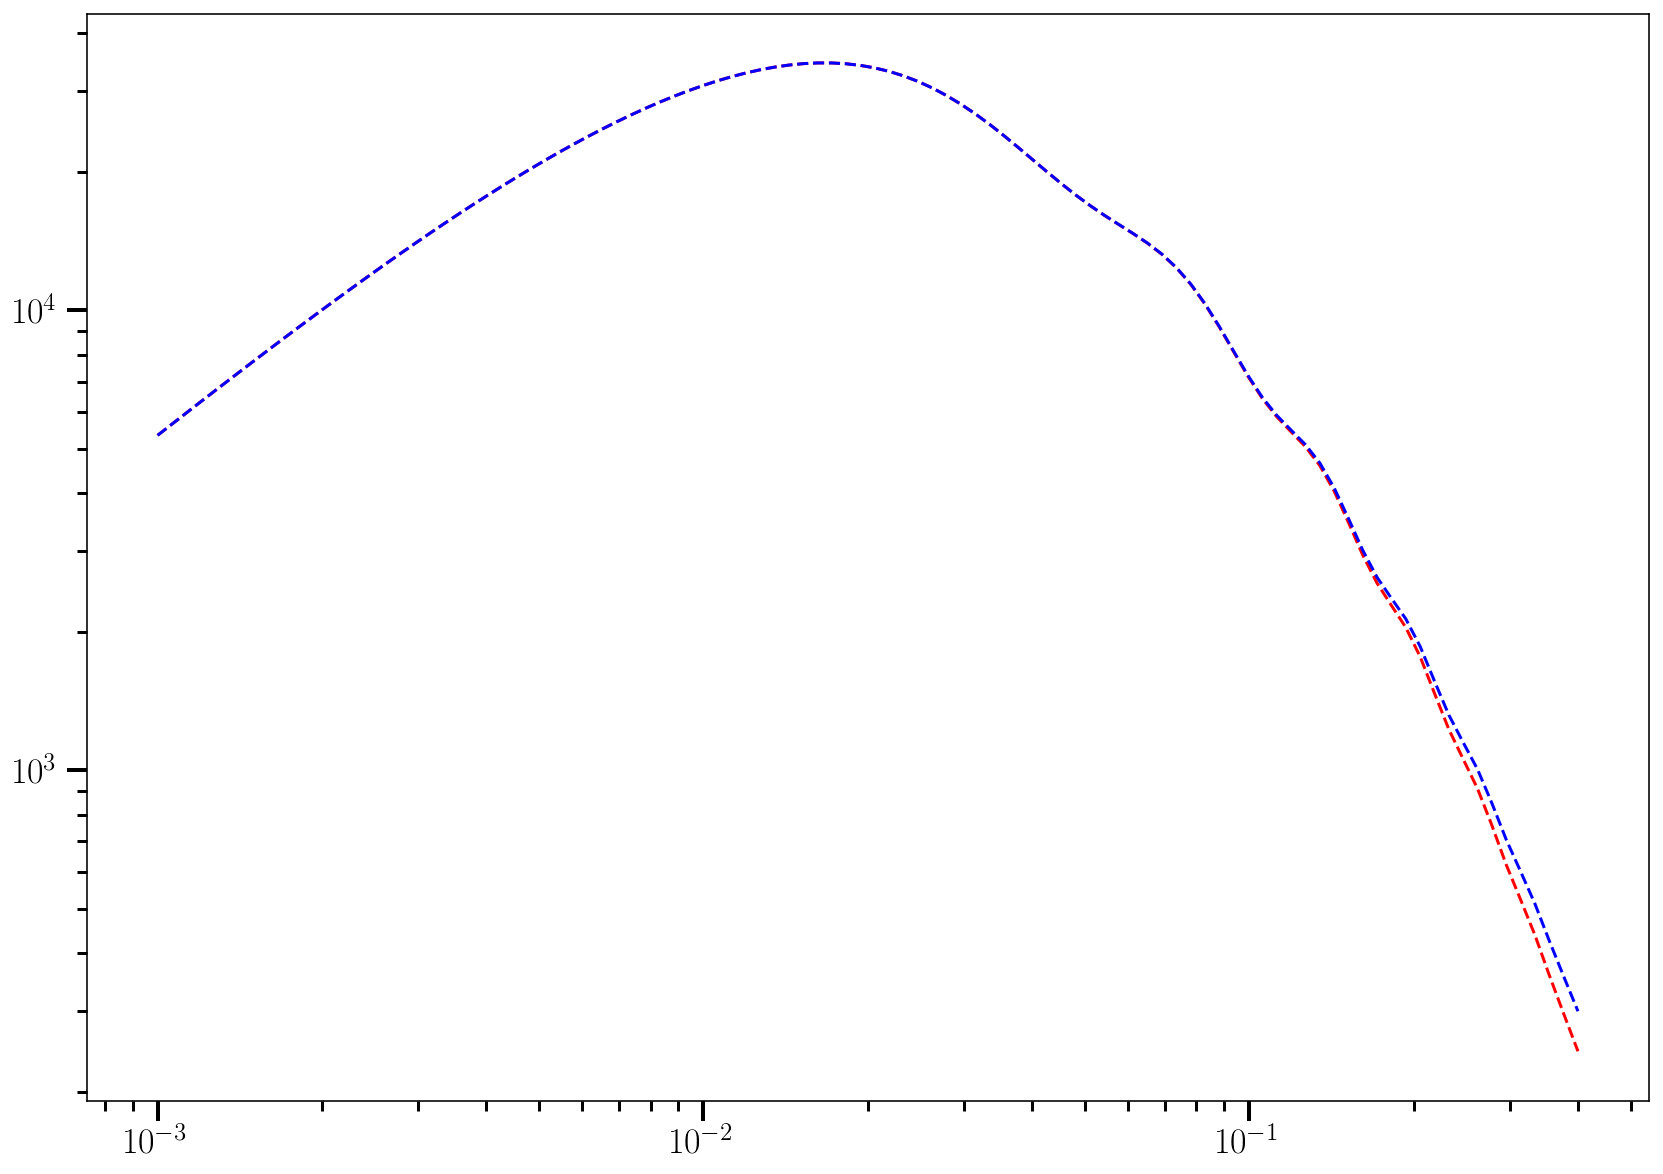

In [531]:
plt.figure(figsize=(14,10))
plt.plot(ks,np.abs(pk_mono_dfog(ks,5.3)),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_mono_dfog1(ks,5.3)),color='blue',linestyle='--')
#plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,5.3,500,0)),color='red',linestyle='--')
#plt.plot(ks,np.abs(pk_mono_dfog1_wa(ks,8,500,0)),color='blue',linestyle='--')
plt.yscale('log')
plt.xscale('log')

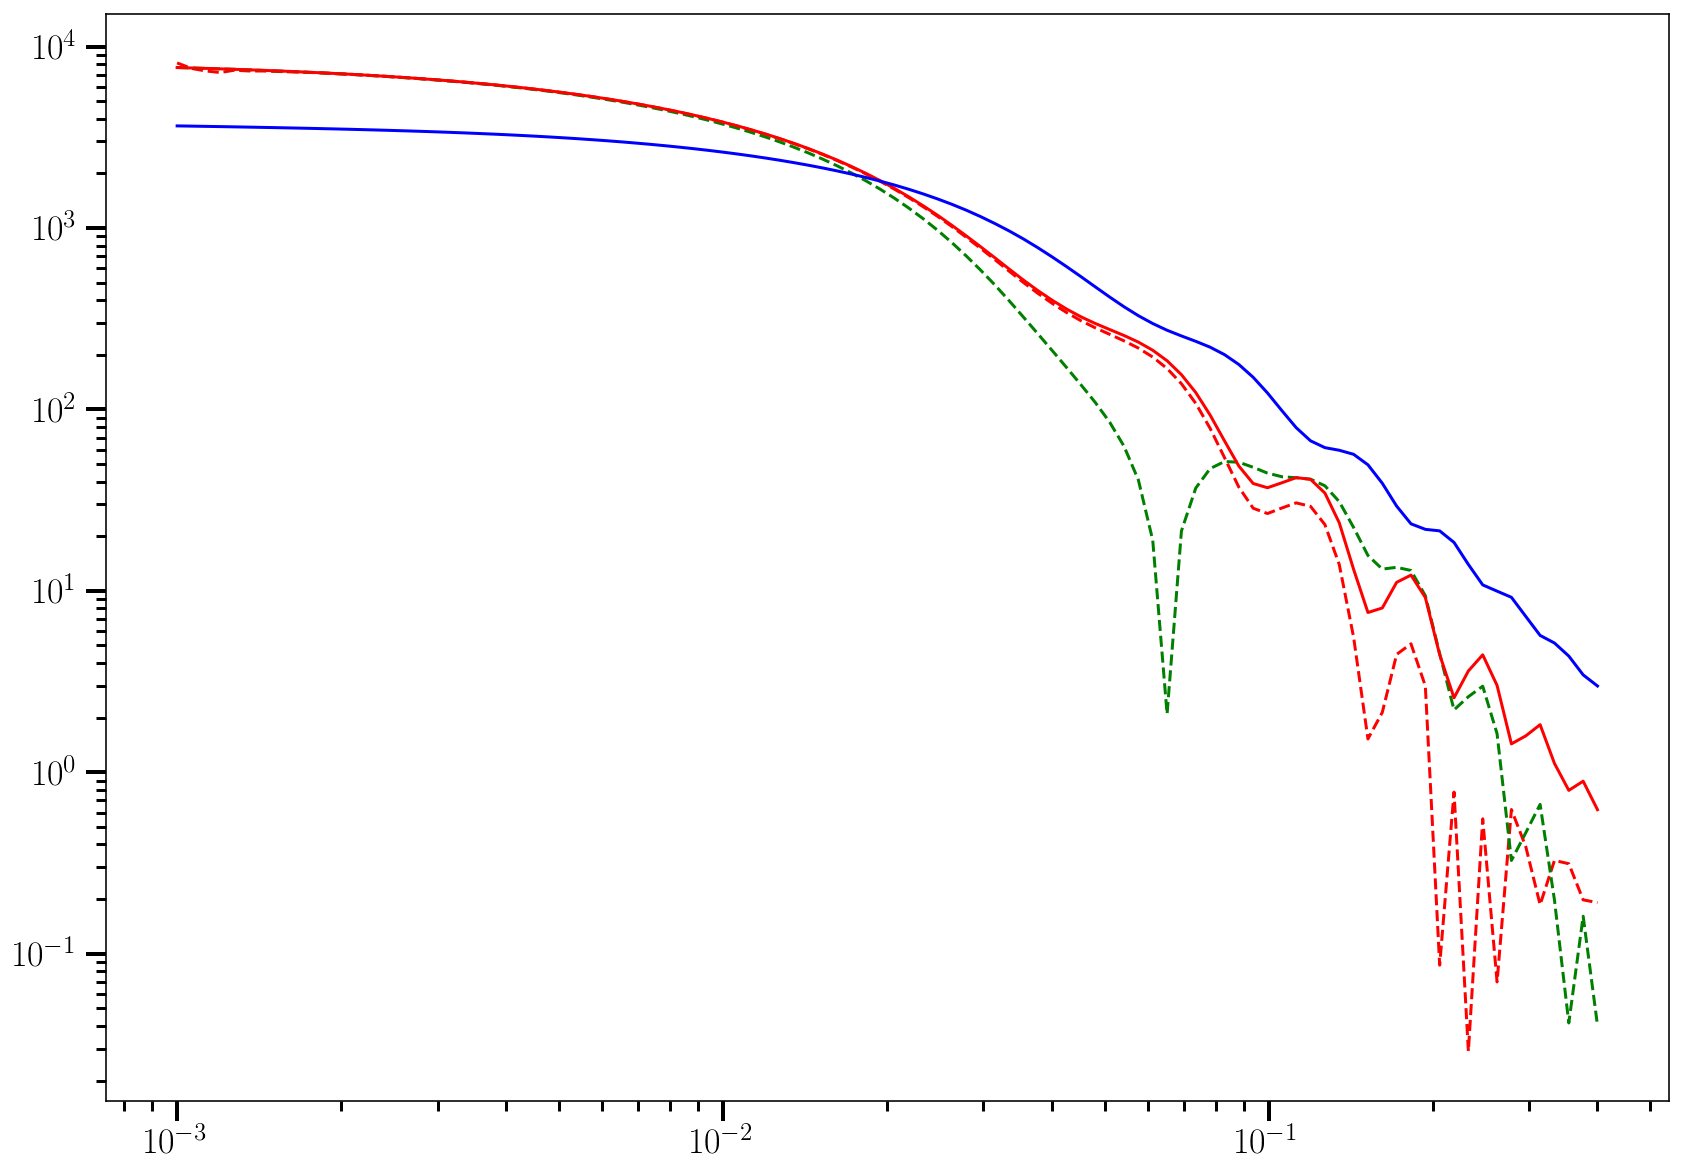

In [391]:
sigma =10
plt.figure(figsize=(14,10))
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,sigma,d,t)),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_dipo_dfog_wa1(ks,10,d,t)),color='green',linestyle='--')
#plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,sigma,d,t)),color='blue',linestyle='--')

plt.plot(ks,Pk_l1_wa,color='red')
plt.plot(ks,-Pk_l3_wa.imag,color='blue')

plt.yscale('log')
plt.xscale('log')

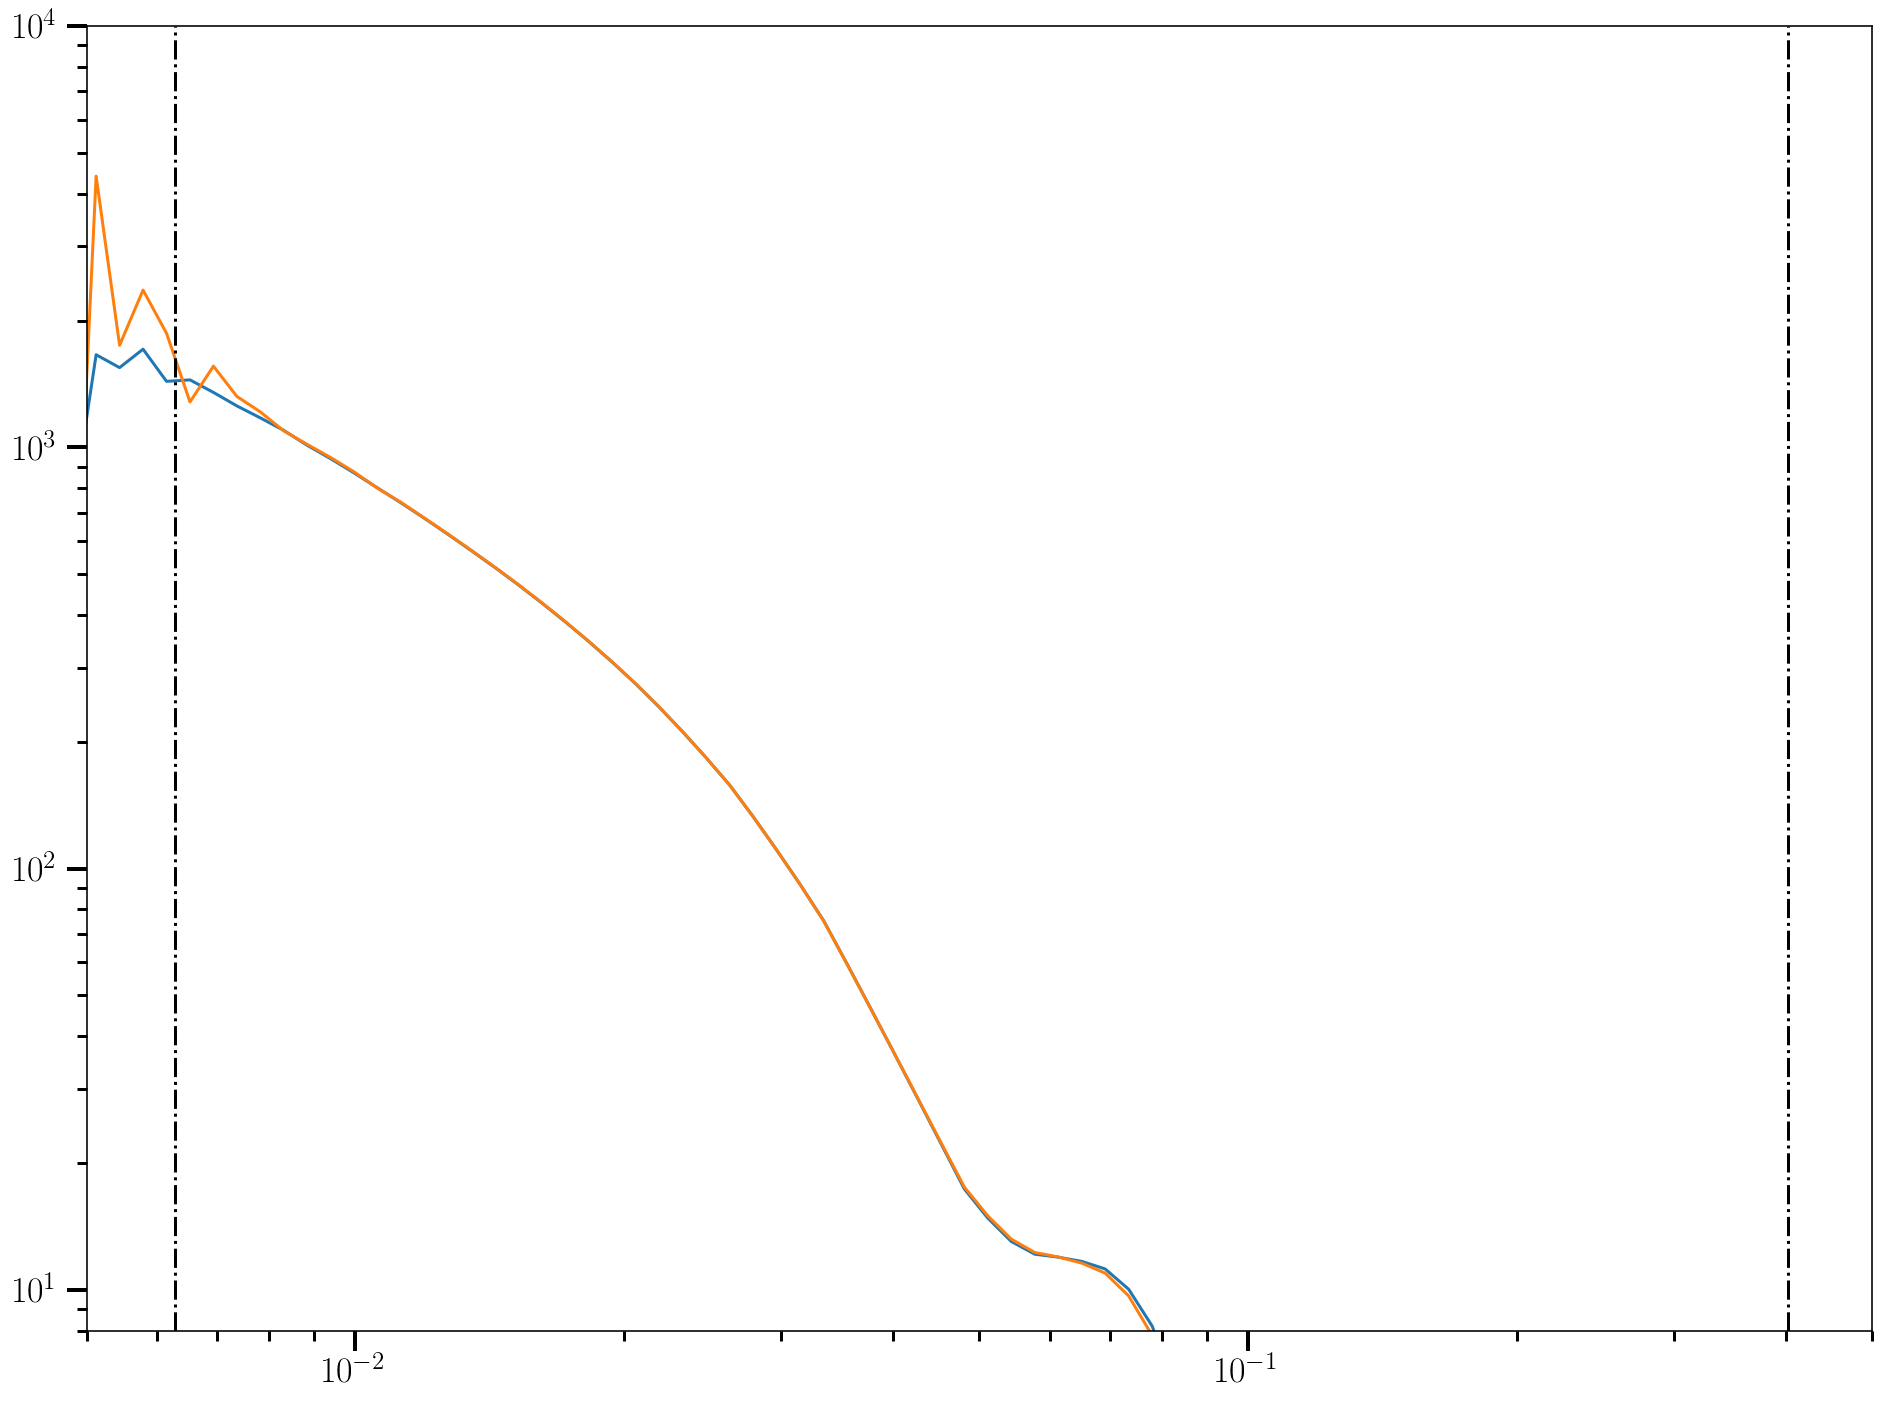

In [380]:
plt.figure(figsize=(16,12))
#plt.plot(ks,Pl2_pp,'k')
plt.plot(ks,-pk_quad_dfog_wa(ks,10,1000,0))
plt.plot(ks,-pk_quad_dfog_wa1(ks,4,1000,0))
#plt.plot(ks,np.abs(Pk_l2_wa))


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')

plt.ylim(0.8e+1,1e+4)
plt.xlim(5e-3,5e-1)
plt.yscale('log')
plt.xscale('log')

NameError: name 'full_dfog' is not defined

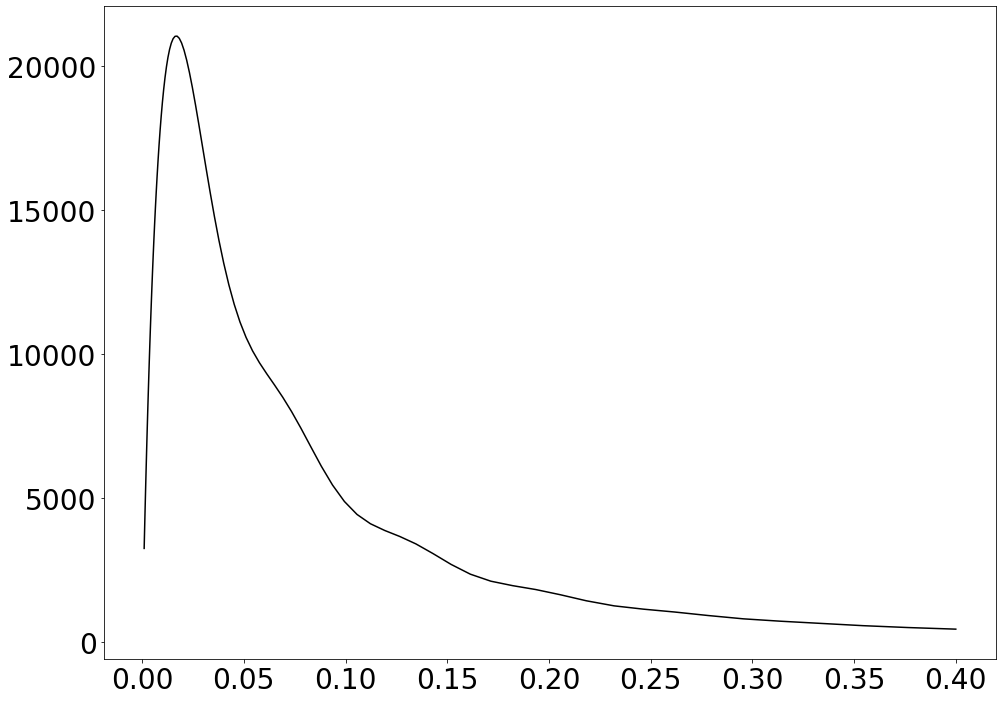

In [97]:
plt.figure(figsize=(16,12))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)))
plt.plot(ks,Pl2_pp,'k')

plt.plot(ks,np.abs(full_dfog(ks,5.22,0)),'-.')
plt.plot(ks,np.abs(full_dfog1(ks,5.22,0)),'-.')
plt.plot(ks,np.abs(full_dfog_inv(ks,5.22,0)),'-.')
#plt.plot(ks,np.abs(full_dfog1(ks,5.22,0)))
#plt.plot(ks,np.abs(full_dfog2(ks,5.22,0)))

plt.plot(ks,np.abs(pk_quad_dfog(ks,10)))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+pk_quad_dfog_wa(ks,10,0)),'--',color='black')
plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+Pk_l2_wa1),'--')

plt.ylim(1e+1,1e+5)
plt.xlim(2e-3,4e-1)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(ks,pk_mono_dfog(ks,5))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+Pk_l0_wa1))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+pk_quad_dfog_wa(ks,10,0)),'--')

plt.plot(ks,Pl0_pp)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,10,0)))
plt.plot(ks,Pk_l1_wa)
#plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(Pk_l0_wa1))

plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--',lw=0.75)